In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = True
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-11-22 08:29:05.010808: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-22 08:29:18.556865: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-11-22 08:29:18.568983: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-22 08:29:18.569018: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-11-22 08:29:18.571724: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-11-22 08:29:18.574463: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load data from the output of Brusselator model

In [2]:
import os

In [3]:
data_path = pathlib.PurePath(os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_2"))
with open(data_path.joinpath(f"Brusselator_2.npy"), "rb") as f:
    data = np.load(f)
with open(data_path.joinpath("simulation.txt"), "r") as f:
    simulation = eval(f.read())

In [4]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_2"),
                                "Brusselator_2", thining_start=-3)

In [5]:
thining_start = -3
t_star = np.linspace(simulation.t_start, simulation.t_end, simulation.t_steps)
# Thining the dataset
t_star = t_star[thining_start:]
data = data[..., thining_start:]

In [6]:
data.shape

(2, 32, 32, 3)

In [7]:
L = 2
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size * y_size
x_domain = L * np.linspace(0, 1, x_size)
y_domain = L * np.linspace(0, 1, y_size)

T = t_star.shape[0]
X, Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")


In [8]:
dxdy = x_size*y_size/L**2
diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [9]:
model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N),#//(32),
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'signal_to_noise':0.00,
                'shuffle':False}

dataset2 = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset2['lb']
ub = dataset2['ub']

obs_X = np.concatenate([dataset2['obs_input'], dataset2['obs_output']], axis=1)
pde_X = dataset2['pde']

pbc_X = np.concatenate([dataset2['boundary_LB'], dataset2['boundary_RT']], axis=1)
diffs = np.concatenate([dataset2['diff_input'], dataset2['diff_output']], axis=1)
diffs_point = np.concatenate([dataset2['obs_input'], dataset2['diff_output']], axis=1)

In [10]:
ds = TINN_Dataset(tf.float32, obs_X, pde_X)

In [11]:
ds2 = TINN_Dataset(tf.float32, obs_X, diffs_point)

In [12]:
ds3 = TINN_Dataset(tf.float32, obs_X, diffs_point, pde_X)

In [13]:
t_star

array([125.98425197, 126.99212598, 128.        ])

In [14]:
class NN_Compound(tu.NN):
    def __init__(self, pre_pinn, lb, ub, pre_lb, pre_ub, layers, skips=None, dtype=tf.float32, **kwargs):
        assert pre_pinn.layers[-1] == layers[0]
        if skips is not None:
            assert len(skips) == len(layers)
        self.pre_Ws = [w.numpy() for w in pre_pinn.Ws]
        self.pre_bs = [b.numpy() for b in pre_pinn.bs]
        self.pre_lb = pre_lb
        self.pre_ub = pre_ub
        self.skips = skips       
        self.swtich_index = -1
        super().__init__(layers, lb, ub, dtype, **kwargs)
        self.lb = tf.expand_dims(tf.Variable(self.lb, dtype=dtype), axis=0)
        self.ub = tf.expand_dims(tf.Variable(self.ub, dtype=dtype), axis=0)
        self.__version__ = 0.1
        
        
    def build(self):
        """Create the state of the layers (weights)"""
        weights = []
        biases = []
        for pre_W, pre_b in zip(self.pre_Ws, self.pre_bs):
            W = tf.Variable(pre_W, 
                            trainable=False,
                            dtype=self.dtype)
            b = tf.Variable(pre_b, 
                            trainable=False,
                            dtype=self.dtype)
            weights.append(W)
            biases.append(b)
            self.swtich_index += 1
            
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)

        self.Ws = weights
        self.bs = biases
            
    @tf.function
    def net(self, inputs):
        #inputs_2 = self.pre_pinn(inputs)
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (inputs - self.pre_lb) / (self.pre_ub - self.pre_lb) - 1.0
        for i, (W, b) in enumerate(zip(self.Ws[:-1], self.bs[:-1])):
            if i == self.swtich_index:
                H = tf.add(tf.matmul(H, W), b)
                H_skip = H
                H = 2.0 * (H - self.lb) / (self.ub - self.lb) - 1.0
            else:
                H = tf.tanh(tf.add(tf.matmul(H, W), b))
                
            if i > self.swtich_index and  self.skips[i - self.swtich_index] == 1:
                H += H_skip
                H_skip = H
                print(f" to layer{i- self.swtich_index}")
                
            if i > self.swtich_index and  self.skips[i - self.swtich_index] == 2:
                print(f" from layer{i- self.swtich_index}")
                H_skip = H                    

        W = self.Ws[-1]
        b = self.bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        if self.skips[-1] == 1:
            outputs += H_skip
            print(f" to layer{len(self.skips)-1}")
        return outputs

        
    

In [9]:
class NN2(tf.Module):
    def __init__(self, layers, L, n, t, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.

        layers: input, dense layers and outputs dimensions
        lb    : An array of minimums of inputs (lower bounds)
        ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)
        self.L = tf.expand_dims(L, axis=0)
        self.n = n
        self.t = t
        self.dtype = dtype
        self.__version__ = 0.1
        self.build()

    def build(self):
        """Create the state of the layers (weights)"""
        x = tf.linspace(0, self.L[0][0], self.n[0])
        y = tf.linspace(0, self.L[0][1], self.n[1])
        X, Y, T = tf.meshgrid(x, y , self.t)
        self.domain = tf.concat([tf.expand_dims(tf.reshape(X, [-1]),axis=1),
                                 tf.expand_dims(tf.reshape(Y, [-1]), axis=1),
                                 tf.expand_dims(tf.reshape(T, [-1]), axis=1)], axis=1)
        
        self.lb = tf.concat([tf.cast(self.L, self.dtype), 
                             tf.reshape(tf.reduce_min(self.t), [1, 1])], axis=1)
        
        weights = []
        biases = []
        for i in range(0, self.num_layers - 1):
            W = self.xavier_init(size=[self.layers[i], self.layers[i + 1]])
            b = tf.Variable(tf.zeros([1, self.layers[i + 1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)

        self.Ws = weights
        self.bs = biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(
            tf.compat.v1.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, dtype=self.dtype), dtype=self.dtype
        )

    @tf.function
    def net(self, dummy):     
        
        
        
        # Map the inputs to the range [-1, 1]
        H = 2.0 * (self.domain / self.lb) - 1.0
        for W, b in zip(self.Ws[:-1], self.bs[:-1]):
            H = tf.tanh(tf.add(tf.matmul(H, W), b))

        W = self.Ws[-1]
        b = self.bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        return outputs

    def __call__(self, dummy):
        """Defines the computation from inputs to outputs

        Args:
           t: time.

        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.
        """       
        return self.net(dummy)

    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: inputs.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.

        Return:   The returns 'partial_1' and 'partial_2' are the first and second
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]

        """                
        partials_1 = [tf.gradients(outputs[:, i], self.domain)[0] for i in range(outputs.shape[1])]
        #print(partials_1)
        partials_2 = [tf.gradients(partials_1[i], self.domain)[0] for i in range(outputs.shape[1])]
        #print(partials_2)
        return partials_1, partials_2

    def gradients_tape(self, inputs, outputs, tape):
        """finds the first and second order griadients of outputs at inputs

        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
           tape:   Gradient Tape object, for eager mode.
                   The outputs must be the list
                   of Tensors.

        Return:   The returns 'partial' gradients. It is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, the list has Dn tensors as an elements. The dimensionality
                  of the tensors is the same as inputs: [None, D1]

        """        
        partials = [tape.gradient(outputs[i], self.domain) for i in range(len(outputs))]
        return partials

    def copy(self):
        return copy.deepcopy(self)


In [10]:
from turing.loss_functions import PDE_Parameter, Parameter_Type
#from turing.utils import Simulation

In [11]:
layers = [3, 256, 256, 256, 256, 2]
pinn = NN2(layers, L=(2,2), n=(100,100), t=t_star, dtype=tf.float64)

In [11]:
pinn.lb

<tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[  2.        ,   2.        , 510.01165049]])>

In [12]:
pinn.domain.numpy()[:10]

array([[0.00000000e+00, 0.00000000e+00, 5.10011650e+02],
       [0.00000000e+00, 0.00000000e+00, 5.11005825e+02],
       [0.00000000e+00, 0.00000000e+00, 5.12000000e+02],
       [2.02020202e-02, 0.00000000e+00, 5.10011650e+02],
       [2.02020202e-02, 0.00000000e+00, 5.11005825e+02],
       [2.02020202e-02, 0.00000000e+00, 5.12000000e+02],
       [4.04040404e-02, 0.00000000e+00, 5.10011650e+02],
       [4.04040404e-02, 0.00000000e+00, 5.11005825e+02],
       [4.04040404e-02, 0.00000000e+00, 5.12000000e+02],
       [6.06060606e-02, 0.00000000e+00, 5.10011650e+02]])

In [13]:
pinn.net(0)

2022-11-09 08:57:38.438769: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


<tf.Tensor: shape=(30000, 2), dtype=float64, numpy=
array([[ 0.06219485,  0.19202625],
       [ 0.06227903,  0.19230783],
       [ 0.06236314,  0.19258923],
       ...,
       [-0.01159643, -0.03504896],
       [-0.01148971, -0.03474414],
       [-0.01138298, -0.03443942]])>

In [14]:
t_star

array([510.01165049, 511.00582524, 512.        ])

In [14]:
#layers = [5, 128, 128, 128, 128, 2]
#layers = [3, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
#pinn = tu.NN2(layers, dataset.lb, dataset.ub, dtype=tf.float64)

layers = [3, 128, 128, 128, 128, 2]
pinn = tu.NN(layers, lb, ub, dtype=tf.float32)

pde_loss = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn.dtype),
                       A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )


obs_loss = Observation_Loss(regularise=True)
model1 = tu.TINN(pinn, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  losses= [obs_loss], 
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                  alpha = 0.9, 
                  print_precision=".8f")

In [15]:
ds.sizes/8

array([384., 384.])

In [70]:
model1.optimizer.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [16]:
results_1 = model1.train(epochs = 30000+1,
                          batch_size = 384,
                          dataset = ds,
                          print_interval=100,
                          stop_threshold = 9e-2,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0


2022-11-21 16:20:20.992701: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-21 16:20:21.715632: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 0.00000000
total loss: 133.15650558, total regularise loss: 133.15650940

Observation_Loss ->  (1): 12.19117057  (2): 4.45339254 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 
Time taken: 2.71s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 89.83017921, total regularise loss: 143.98747253

Observation_Loss ->  (1): 11.14144623  (2): 0.08732603 


lambdas (1): 1.65115774 lambdas (2): 0.34884226 
Time taken: 6.46s

Start of epoch 200
Training observations acc over epoch: 0.00000000
total loss: 89.82995033, total regularise loss: 166.30456543

Observation_Loss ->  (1): 11.14140975  (2): 0.08733417 


lambdas (1): 1.87828875 lambdas (2): 0.12171124 
Time taken: 5.63s

Start of epoch 300
Training observations acc over epoch: 0.00000000
total loss: 89.82909775, total regularise loss: 174.07858276

Observation_Loss ->  (1): 11.14091098  (2): 0.08772617 


lambdas (1): 1.95748484 lambdas (2): 0.04251509 
Time taken: 5


Start of epoch 3300
Training observations acc over epoch: 0.00000000
total loss: 23.33135319, total regularise loss: 45.97783661

Observation_Loss ->  (1): 2.88358793  (2): 0.03283122 


lambdas (1): 1.99331784 lambdas (2): 0.00668237 
Time taken: 5.29s

Start of epoch 3400
Training observations acc over epoch: 0.00000000
total loss: 21.28090608, total regularise loss: 41.90791702

Observation_Loss ->  (1): 2.63142785  (2): 0.02868539 


lambdas (1): 1.99116433 lambdas (2): 0.00883572 
Time taken: 5.49s

Start of epoch 3500
Training observations acc over epoch: 0.00000000
total loss: 19.43374729, total regularise loss: 38.30369568

Observation_Loss ->  (1): 2.40371874  (2): 0.02549964 


lambdas (1): 1.99215829 lambdas (2): 0.00784200 
Time taken: 5.46s

Start of epoch 3600
Training observations acc over epoch: 0.00000000
total loss: 17.86508203, total regularise loss: 35.17613602

Observation_Loss ->  (1): 2.21002512  (2): 0.02311017 


lambdas (1): 1.99000347 lambdas (2): 0.00999673


Start of epoch 6600
Training observations acc over epoch: 0.00000000
total loss: 4.06801009, total regularise loss: 7.84723282

Observation_Loss ->  (1): 0.50047501  (2): 0.00802624 


lambdas (1): 1.96160543 lambdas (2): 0.03839441 
Time taken: 5.22s

Start of epoch 6700
Training observations acc over epoch: 0.00000000
total loss: 3.96788870, total regularise loss: 7.68163633

Observation_Loss ->  (1): 0.48804922  (2): 0.00793686 


lambdas (1): 1.96647608 lambdas (2): 0.03352391 
Time taken: 5.37s

Start of epoch 6800
Training observations acc over epoch: 0.00000000
total loss: 4.68826960, total regularise loss: 9.05330849

Observation_Loss ->  (1): 0.57744278  (2): 0.00859091 


lambdas (1): 1.95849407 lambdas (2): 0.04150601 
Time taken: 5.33s

Start of epoch 6900
Training observations acc over epoch: 0.00000000
total loss: 3.82645780, total regularise loss: 7.36408806

Observation_Loss ->  (1): 0.47051709  (2): 0.00779014 


lambdas (1): 1.95509005 lambdas (2): 0.04491001 
Time t


Start of epoch 9900
Training observations acc over epoch: 0.00000000
total loss: 2.58180350, total regularise loss: 4.95348120

Observation_Loss ->  (1): 0.31613661  (2): 0.00658883 


lambdas (1): 1.95969331 lambdas (2): 0.04030674 
Time taken: 5.21s

Start of epoch 10000
Training observations acc over epoch: 0.00000000
total loss: 2.54213014, total regularise loss: 4.88530159

Observation_Loss ->  (1): 0.31121956  (2): 0.00654671 


lambdas (1): 1.96175981 lambdas (2): 0.03824026 
Time taken: 5.48s

Start of epoch 10100
Training observations acc over epoch: 0.00000000
total loss: 2.49507648, total regularise loss: 4.78224611

Observation_Loss ->  (1): 0.30537805  (2): 0.00650651 


lambdas (1): 1.95834351 lambdas (2): 0.04165663 
Time taken: 5.66s

Start of epoch 10200
Training observations acc over epoch: 0.00000000
total loss: 2.46423259, total regularise loss: 4.72931719

Observation_Loss ->  (1): 0.30154287  (2): 0.00648620 


lambdas (1): 1.95947576 lambdas (2): 0.04052420 
Tim


Start of epoch 13200
Training observations acc over epoch: 0.00000000
total loss: 1.60924202, total regularise loss: 3.00658464

Observation_Loss ->  (1): 0.19549610  (2): 0.00565916 


lambdas (1): 1.91930008 lambdas (2): 0.08069989 
Time taken: 5.33s

Start of epoch 13300
Training observations acc over epoch: 0.00000000
total loss: 1.53195457, total regularise loss: 2.85510159

Observation_Loss ->  (1): 0.18590418  (2): 0.00559014 


lambdas (1): 1.91636908 lambdas (2): 0.08363091 
Time taken: 5.23s

Start of epoch 13400
Training observations acc over epoch: 0.00000000
total loss: 1.50630711, total regularise loss: 2.78824568

Observation_Loss ->  (1): 0.18272871  (2): 0.00555968 


lambdas (1): 1.90428996 lambdas (2): 0.09571006 
Time taken: 5.38s

Start of epoch 13500
Training observations acc over epoch: 0.00000000
total loss: 4.80075081, total regularise loss: 9.09680748

Observation_Loss ->  (1): 0.59164622  (2): 0.00844763 


lambdas (1): 1.92437410 lambdas (2): 0.07562581 
Ti


Start of epoch 16500
Training observations acc over epoch: 0.00000000
total loss: 0.56323490, total regularise loss: 0.93269640

Observation_Loss ->  (1): 0.06576042  (2): 0.00464394 


lambdas (1): 1.75395608 lambdas (2): 0.24604404 
Time taken: 5.50s

Start of epoch 16600
Training observations acc over epoch: 0.00000000
total loss: 0.57518194, total regularise loss: 0.92664570

Observation_Loss ->  (1): 0.06722919  (2): 0.00466855 


lambdas (1): 1.68889081 lambdas (2): 0.31110919 
Time taken: 5.30s

Start of epoch 16700
Training observations acc over epoch: 0.00000000
total loss: 0.82580693, total regularise loss: 1.29251933

Observation_Loss ->  (1): 0.09834356  (2): 0.00488231 


lambdas (1): 1.62224674 lambdas (2): 0.37775314 
Time taken: 5.43s

Start of epoch 16800
Training observations acc over epoch: 0.00000000
total loss: 0.48900946, total regularise loss: 0.76249349

Observation_Loss ->  (1): 0.05654709  (2): 0.00457909 


lambdas (1): 1.67520380 lambdas (2): 0.32479599 
Ti


Start of epoch 19800
Training observations acc over epoch: 0.00000000
total loss: 0.17073810, total regularise loss: 0.17114593

Observation_Loss ->  (1): 0.01728848  (2): 0.00405378 


lambdas (1): 0.99073285 lambdas (2): 1.00926709 
Time taken: 5.30s

Start of epoch 19900
Training observations acc over epoch: 0.00000000
total loss: 0.16394097, total regularise loss: 0.17152628

Observation_Loss ->  (1): 0.01644603  (2): 0.00404659 


lambdas (1): 1.07412648 lambdas (2): 0.92587352 
Time taken: 5.17s

Start of epoch 20000
Training observations acc over epoch: 0.00000000
total loss: 0.16130733, total regularise loss: 0.16304654

Observation_Loss ->  (1): 0.01614236  (2): 0.00402105 


lambdas (1): 1.03782094 lambdas (2): 0.96217906 
Time taken: 5.49s

Start of epoch 20100
Training observations acc over epoch: 0.00000000
total loss: 0.15643623, total regularise loss: 0.16183928

Observation_Loss ->  (1): 0.01553887  (2): 0.00401566 


lambdas (1): 1.05396330 lambdas (2): 0.94603664 
Ti


Start of epoch 23100
Training observations acc over epoch: 0.00000000
total loss: 0.09502513, total regularise loss: 0.07560474

Observation_Loss ->  (1): 0.00859559  (2): 0.00328255 


lambdas (1): 0.56254005 lambdas (2): 1.43746018 
Time taken: 5.30s

Start of epoch 23200
Training observations acc over epoch: 0.00000000
total loss: 0.09500682, total regularise loss: 0.08105090

Observation_Loss ->  (1): 0.00859657  (2): 0.00327929 


lambdas (1): 0.69267511 lambdas (2): 1.30732501 
Time taken: 4.94s

Start of epoch 23300
Training observations acc over epoch: 0.00000000
total loss: 0.09438787, total regularise loss: 0.08388039

Observation_Loss ->  (1): 0.00852337  (2): 0.00327511 


lambdas (1): 0.72793114 lambdas (2): 1.27206910 
Time taken: 5.24s

Start of epoch 23400
Training observations acc over epoch: 0.00000000
total loss: 0.09300644, total regularise loss: 0.07805642

Observation_Loss ->  (1): 0.00838601  (2): 0.00323979 


lambdas (1): 0.62863278 lambdas (2): 1.37136734 
Ti

In [17]:
model1.save(".", "double_pinn_part_one")

In [37]:
model1 = tu.TINN.restore(".", "double_pinn_part_one", ds)

In [38]:
pinn = model1.pinn
obs_loss = model1.losses[0]

In [39]:
lb2 = np.min(dataset2['obs_output'], axis=0)
ub2 = np.max(dataset2['obs_output'], axis=0)

#layers2 = [2, 256, 256,  2]
#skips =   [2, 0,   0,   1]
#layers2 = [2, 256, 256, 256, 2]
#skips =   [0, 2,   0, 1,   0]

layers2 = [2, 256, 256, 2]
skips =   [0, 0,   0,  1]

pinn2 = NN_Compound(pinn,lb2, ub2, lb, ub,layers2, skips, dtype=tf.float32)

diff_loss_point = Diffusion_point_Loss(
                           Ds = simulation.Ds,
                           dtype = pinn.dtype)
diff_loss = Diffusion_Loss(ns = simulation.n,
                           Ls = simulation.L,
                           Ds = simulation.Ds,
                           dtype = pinn.dtype)

In [40]:
data.shape

(2, 32, 32, 3)

In [41]:
model2 = tu.TINN(pinn2, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  losses= [obs_loss, diff_loss_point], 
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.2, 
                  print_precision=".8f")

In [35]:
ds2.sizes

array([3072, 3072])

In [42]:
results_2_2 = model2.train(epochs = 1000+1,
                          batch_size = 384,
                          dataset = ds2,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=False,
                          regularise_interval=10)


Start of epoch 0
 to layer3
Training observations acc over epoch: 0.00000000
total loss: 51064.41113281, total regularise loss: 51064.41015625

Observation_Loss ->  (1): 0.02164939  (2): 0.32175351 
Diffusion_Point_Loss ->  (1): 3369.90052795  (2): 3012.80747414 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 11.86s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 889.71156311, total regularise loss: 889.71154785

Observation_Loss ->  (1): 12.14095402  (2): 0.11900034 
Diffusion_Point_Loss ->  (1): 39.86547470  (2): 59.08851576 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.70s

Start of epoch 200
Training observations acc over epoch: 0.00000000
total loss: 827.44773865, total regularise loss: 827.44775391

Observation_Loss ->  (1): 10.63858950  (2): 0.07768542 
Diffusion_Point_Loss ->  (1): 35.51348352  (2): 57.20120907 

In [43]:
results_2_3 = model2.train(epochs = 10000+1,
                          batch_size = 384,
                          dataset = ds2,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=False,
                          regularise_interval=10)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 707.48102570, total regularise loss: 707.48101807

Observation_Loss ->  (1): 7.03177226  (2): 0.07094688 
Diffusion_Point_Loss ->  (1): 28.61992741  (2): 52.71248150 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 0.48s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 848.41200256, total regularise loss: 848.41204834

Observation_Loss ->  (1): 6.96546543  (2): 0.07122832 
Diffusion_Point_Loss ->  (1): 28.59116888  (2): 70.42363787 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.37s

Start of epoch 200
Training observations acc over epoch: 0.00000000
total loss: 701.09134674, total regularise loss: 701.09136963

Observation_Loss ->  (1): 6.95776093  (2): 0.07175936 
Diffusion_Point_Loss ->  (1): 28.27907610  (2): 52.32782269 


lambdas (1): 1.0000


Start of epoch 2300
Training observations acc over epoch: 0.00000000
total loss: 595.98964310, total regularise loss: 595.98962402

Observation_Loss ->  (1): 0.15570298  (2): 0.06136133 
Diffusion_Point_Loss ->  (1): 25.71193075  (2): 48.56971025 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.91s

Start of epoch 2400
Training observations acc over epoch: 0.00000000
total loss: 589.37699509, total regularise loss: 589.37695312

Observation_Loss ->  (1): 0.14100550  (2): 0.05629604 
Diffusion_Point_Loss ->  (1): 25.68207693  (2): 47.79274416 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.89s

Start of epoch 2500
Training observations acc over epoch: 0.00000000
total loss: 570.89268494, total regularise loss: 570.89263916

Observation_Loss ->  (1): 0.14145030  (2): 0.04282535 
Diffusion_Point_Loss ->  (1): 25.40754557  (2): 45.76976490 


lambdas (1): 


Start of epoch 4600
Training observations acc over epoch: 0.00000000
total loss: 460.08696365, total regularise loss: 460.08700562

Observation_Loss ->  (1): 0.13066094  (2): 0.01288927 
Diffusion_Point_Loss ->  (1): 20.38785565  (2): 36.97946596 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.88s

Start of epoch 4700
Training observations acc over epoch: 0.00000000
total loss: 458.21820831, total regularise loss: 458.21823120

Observation_Loss ->  (1): 0.13026384  (2): 0.01254554 
Diffusion_Point_Loss ->  (1): 20.31683528  (2): 36.81763148 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.45s

Start of epoch 4800
Training observations acc over epoch: 0.00000000
total loss: 456.28209686, total regularise loss: 456.28210449

Observation_Loss ->  (1): 0.12987184  (2): 0.01231239 
Diffusion_Point_Loss ->  (1): 20.24840748  (2): 36.64467025 


lambdas (1): 


Start of epoch 6900
Training observations acc over epoch: 0.00000000
total loss: 395.23639107, total regularise loss: 395.23638916

Observation_Loss ->  (1): 0.12457782  (2): 0.01197813 
Diffusion_Point_Loss ->  (1): 18.16626215  (2): 31.10173082 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.66s

Start of epoch 7000
Training observations acc over epoch: 0.00000000
total loss: 387.90860748, total regularise loss: 387.90856934

Observation_Loss ->  (1): 0.12431730  (2): 0.01192806 
Diffusion_Point_Loss ->  (1): 17.96568799  (2): 30.38664103 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 11.25s

Start of epoch 7100
Training observations acc over epoch: 0.00000000
total loss: 380.56747246, total regularise loss: 380.56747437

Observation_Loss ->  (1): 0.12394537  (2): 0.01187861 
Diffusion_Point_Loss ->  (1): 17.73522866  (2): 29.69988179 


lambdas (1): 


Start of epoch 9200
Training observations acc over epoch: 0.00000000
total loss: 264.67561150, total regularise loss: 264.67562866

Observation_Loss ->  (1): 0.11744849  (2): 0.01197625 
Diffusion_Point_Loss ->  (1): 12.79943883  (2): 20.15558803 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.73s

Start of epoch 9300
Training observations acc over epoch: 0.00000000
total loss: 259.98451614, total regularise loss: 259.98452759

Observation_Loss ->  (1): 0.11724355  (2): 0.01193501 
Diffusion_Point_Loss ->  (1): 12.62002289  (2): 19.74886334 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 11.11s

Start of epoch 9400
Training observations acc over epoch: 0.00000000
total loss: 258.28543854, total regularise loss: 258.28543091

Observation_Loss ->  (1): 0.11727826  (2): 0.01192387 
Diffusion_Point_Loss ->  (1): 12.49724019  (2): 19.65923727 


lambdas (1): 

In [47]:
model2.optimizer.lr.assign(2e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0002>

In [48]:
results_2_4 = model2.train(epochs = 30000+1,
                          batch_size = 384,
                          dataset = ds2,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=False,
                          regularise_interval=10)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 442.51840782, total regularise loss: 442.51834106

Observation_Loss ->  (1): 0.21636573  (2): 0.02205424 
Diffusion_Point_Loss ->  (1): 21.69385242  (2): 33.38252878 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 0.34s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 233.36106300, total regularise loss: 233.36105347

Observation_Loss ->  (1): 0.11484633  (2): 0.01175571 
Diffusion_Point_Loss ->  (1): 11.35881013  (2): 17.68472040 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.76s

Start of epoch 200
Training observations acc over epoch: 0.00000000
total loss: 232.46746063, total regularise loss: 232.46746826

Observation_Loss ->  (1): 0.11481018  (2): 0.01175344 
Diffusion_Point_Loss ->  (1): 11.32526100  (2): 17.60660756 


lambdas (1): 1.0000


Start of epoch 2300
Training observations acc over epoch: 0.00000000
total loss: 224.91178322, total regularise loss: 224.91177368

Observation_Loss ->  (1): 0.11430220  (2): 0.01175350 
Diffusion_Point_Loss ->  (1): 10.87541097  (2): 17.11250639 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.44s

Start of epoch 2400
Training observations acc over epoch: 0.00000000
total loss: 224.64766502, total regularise loss: 224.64767456

Observation_Loss ->  (1): 0.11432682  (2): 0.01175302 
Diffusion_Point_Loss ->  (1): 10.85999167  (2): 17.09488666 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.37s

Start of epoch 2500
Training observations acc over epoch: 0.00000000
total loss: 224.38957977, total regularise loss: 224.38957214

Observation_Loss ->  (1): 0.11435782  (2): 0.01175298 
Diffusion_Point_Loss ->  (1): 10.84497869  (2): 17.07760811 


lambdas (1): 


Start of epoch 4600
Training observations acc over epoch: 0.00000000
total loss: 220.01506805, total regularise loss: 220.01507568

Observation_Loss ->  (1): 0.11581879  (2): 0.01177911 
Diffusion_Point_Loss ->  (1): 10.61523211  (2): 16.75905323 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.62s

Start of epoch 4700
Training observations acc over epoch: 0.00000000
total loss: 219.85164261, total regularise loss: 219.85163879

Observation_Loss ->  (1): 0.11588819  (2): 0.01178082 
Diffusion_Point_Loss ->  (1): 10.60793757  (2): 16.74584889 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.19s

Start of epoch 4800
Training observations acc over epoch: 0.00000000
total loss: 219.69085121, total regularise loss: 219.69084167

Observation_Loss ->  (1): 0.11595667  (2): 0.01178249 
Diffusion_Point_Loss ->  (1): 10.60086757  (2): 16.73274970 


lambdas (1): 


Start of epoch 6900
Training observations acc over epoch: 0.00000000
total loss: 216.65118217, total regularise loss: 216.65118408

Observation_Loss ->  (1): 0.11730008  (2): 0.01179283 
Diffusion_Point_Loss ->  (1): 10.48244488  (2): 16.46985960 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.96s

Start of epoch 7000
Training observations acc over epoch: 0.00000000
total loss: 216.50849533, total regularise loss: 216.50849915

Observation_Loss ->  (1): 0.11735317  (2): 0.01179266 
Diffusion_Point_Loss ->  (1): 10.47734421  (2): 16.45707214 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.59s

Start of epoch 7100
Training observations acc over epoch: 0.00000000
total loss: 216.36415291, total regularise loss: 216.36413574

Observation_Loss ->  (1): 0.11740453  (2): 0.01179247 
Diffusion_Point_Loss ->  (1): 10.47220558  (2): 16.44411659 


lambdas (1): 


Start of epoch 9200
Training observations acc over epoch: 0.00000000
total loss: 212.87709236, total regularise loss: 212.87709045

Observation_Loss ->  (1): 0.11831546  (2): 0.01179162 
Diffusion_Point_Loss ->  (1): 10.35043555  (2): 16.12909377 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.17s

Start of epoch 9300
Training observations acc over epoch: 0.00000000
total loss: 212.67918396, total regularise loss: 212.67919922

Observation_Loss ->  (1): 0.11835823  (2): 0.01179182 
Diffusion_Point_Loss ->  (1): 10.34360415  (2): 16.11114419 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.21s

Start of epoch 9400
Training observations acc over epoch: 0.00000000
total loss: 212.47938156, total regularise loss: 212.47938538

Observation_Loss ->  (1): 0.11840149  (2): 0.01179204 
Diffusion_Point_Loss ->  (1): 10.33670235  (2): 16.09302664 


lambdas (1): 


Start of epoch 11500
Training observations acc over epoch: 0.00000000
total loss: 207.56393242, total regularise loss: 207.56394958

Observation_Loss ->  (1): 0.11944870  (2): 0.01180003 
Diffusion_Point_Loss ->  (1): 10.16627103  (2): 15.64797175 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.59s

Start of epoch 11600
Training observations acc over epoch: 0.00000000
total loss: 207.30533218, total regularise loss: 207.30532837

Observation_Loss ->  (1): 0.11950692  (2): 0.01180051 
Diffusion_Point_Loss ->  (1): 10.15713507  (2): 15.62472415 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.58s

Start of epoch 11700
Training observations acc over epoch: 0.00000000
total loss: 207.04688835, total regularise loss: 207.04687500

Observation_Loss ->  (1): 0.11956612  (2): 0.01180102 
Diffusion_Point_Loss ->  (1): 10.14795905  (2): 15.60153461 


lambdas (1


Start of epoch 13800
Training observations acc over epoch: 0.00000000
total loss: 201.39953613, total regularise loss: 201.39952087

Observation_Loss ->  (1): 0.12090025  (2): 0.01181994 
Diffusion_Point_Loss ->  (1): 9.93451494  (2): 15.10770702 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.94s

Start of epoch 13900
Training observations acc over epoch: 0.00000000
total loss: 201.12113190, total regularise loss: 201.12112427

Observation_Loss ->  (1): 0.12096544  (2): 0.01182122 
Diffusion_Point_Loss ->  (1): 9.92318976  (2): 15.08416498 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.42s

Start of epoch 14000
Training observations acc over epoch: 0.00000000
total loss: 200.84374428, total regularise loss: 200.84375000

Observation_Loss ->  (1): 0.12103061  (2): 0.01182251 
Diffusion_Point_Loss ->  (1): 9.91182899  (2): 15.06078625 


lambdas (1): 


Start of epoch 16100
Training observations acc over epoch: 0.00000000
total loss: 195.17817116, total regularise loss: 195.17816162

Observation_Loss ->  (1): 0.12234285  (2): 0.01183905 
Diffusion_Point_Loss ->  (1): 9.66590136  (2): 14.59718812 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.74s

Start of epoch 16200
Training observations acc over epoch: 0.00000000
total loss: 194.93539619, total regularise loss: 194.93539429

Observation_Loss ->  (1): 0.12239618  (2): 0.01183853 
Diffusion_Point_Loss ->  (1): 9.65507549  (2): 14.57761419 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.63s

Start of epoch 16300
Training observations acc over epoch: 0.00000000
total loss: 194.69610596, total regularise loss: 194.69610596

Observation_Loss ->  (1): 0.12244886  (2): 0.01183805 
Diffusion_Point_Loss ->  (1): 9.64441639  (2): 14.55831015 


lambdas (1): 


Start of epoch 18400
Training observations acc over epoch: 0.00000000
total loss: 190.57719994, total regularise loss: 190.57719421

Observation_Loss ->  (1): 0.12351938  (2): 0.01182608 
Diffusion_Point_Loss ->  (1): 9.47007781  (2): 14.21672642 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.17s

Start of epoch 18500
Training observations acc over epoch: 0.00000000
total loss: 190.41114807, total regularise loss: 190.41116333

Observation_Loss ->  (1): 0.12357094  (2): 0.01182478 
Diffusion_Point_Loss ->  (1): 9.46353638  (2): 14.20246172 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.61s

Start of epoch 18600
Training observations acc over epoch: 0.00000000
total loss: 190.24664688, total regularise loss: 190.24664307

Observation_Loss ->  (1): 0.12362223  (2): 0.01182348 
Diffusion_Point_Loss ->  (1): 9.45706522  (2): 14.18831921 


lambdas (1): 


Start of epoch 20700
Training observations acc over epoch: 0.00000000
total loss: 186.76109886, total regularise loss: 186.76109314

Observation_Loss ->  (1): 0.12476599  (2): 0.01182242 
Diffusion_Point_Loss ->  (1): 9.32424217  (2): 13.88430667 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.25s

Start of epoch 20800
Training observations acc over epoch: 0.00000000
total loss: 186.59223175, total regularise loss: 186.59223938

Observation_Loss ->  (1): 0.12482921  (2): 0.01182334 
Diffusion_Point_Loss ->  (1): 9.31809980  (2): 13.86927664 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.25s

Start of epoch 20900
Training observations acc over epoch: 0.00000000
total loss: 186.42622566, total regularise loss: 186.42622375

Observation_Loss ->  (1): 0.12489314  (2): 0.01182429 
Diffusion_Point_Loss ->  (1): 9.31209105  (2): 13.85446930 


lambdas (1): 


Start of epoch 23000
Training observations acc over epoch: 0.00000000
total loss: 183.30530167, total regularise loss: 183.30531311

Observation_Loss ->  (1): 0.12619644  (2): 0.01184839 
Diffusion_Point_Loss ->  (1): 9.19922090  (2): 13.57589769 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.60s

Start of epoch 23100
Training observations acc over epoch: 0.00000000
total loss: 183.18222237, total regularise loss: 183.18223572

Observation_Loss ->  (1): 0.12625055  (2): 0.01184968 
Diffusion_Point_Loss ->  (1): 9.19463074  (2): 13.56504679 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 11.12s

Start of epoch 23200
Training observations acc over epoch: 0.00000000
total loss: 183.06388664, total regularise loss: 183.06387329

Observation_Loss ->  (1): 0.12630354  (2): 0.01185097 
Diffusion_Point_Loss ->  (1): 9.19019121  (2): 13.55463994 


lambdas (1): 


Start of epoch 25300
Training observations acc over epoch: 0.00000000
total loss: 180.77787590, total regularise loss: 180.77789307

Observation_Loss ->  (1): 0.12709729  (2): 0.01188466 
Diffusion_Point_Loss ->  (1): 9.10220224  (2): 13.35605061 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.99s

Start of epoch 25400
Training observations acc over epoch: 0.00000000
total loss: 180.68442345, total regularise loss: 180.68441772

Observation_Loss ->  (1): 0.12712061  (2): 0.01188647 
Diffusion_Point_Loss ->  (1): 9.09856582  (2): 13.34798038 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.88s

Start of epoch 25500
Training observations acc over epoch: 0.00000000
total loss: 180.72509575, total regularise loss: 180.72509766

Observation_Loss ->  (1): 0.12713945  (2): 0.01188712 
Diffusion_Point_Loss ->  (1): 9.09886152  (2): 13.35274911 


lambdas (1): 


Start of epoch 27600
Training observations acc over epoch: 0.00000000
total loss: 179.30638313, total regularise loss: 179.30639648

Observation_Loss ->  (1): 0.12746375  (2): 0.01191905 
Diffusion_Point_Loss ->  (1): 9.03351551  (2): 13.24039984 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.78s

Start of epoch 27700
Training observations acc over epoch: 0.00000000
total loss: 179.77373314, total regularise loss: 179.77375793

Observation_Loss ->  (1): 0.12748871  (2): 0.01191604 
Diffusion_Point_Loss ->  (1): 9.05050910  (2): 13.28180325 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.39s

Start of epoch 27800
Training observations acc over epoch: 0.00000000
total loss: 180.83302116, total regularise loss: 180.83302307

Observation_Loss ->  (1): 0.12743974  (2): 0.01190996 
Diffusion_Point_Loss ->  (1): 9.08108169  (2): 13.38369620 


lambdas (1): 


Start of epoch 29900
Training observations acc over epoch: 0.00000000
total loss: 178.69757271, total regularise loss: 178.69757080

Observation_Loss ->  (1): 0.12754027  (2): 0.01191564 
Diffusion_Point_Loss ->  (1): 8.99976778  (2): 13.19797289 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.39s

Start of epoch 30000
Training observations acc over epoch: 0.00000000
total loss: 178.17536926, total regularise loss: 178.17536926

Observation_Loss ->  (1): 0.12732698  (2): 0.01190700 
Diffusion_Point_Loss ->  (1): 8.98749298  (2): 13.14519405 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 

Time taken: 10.20s


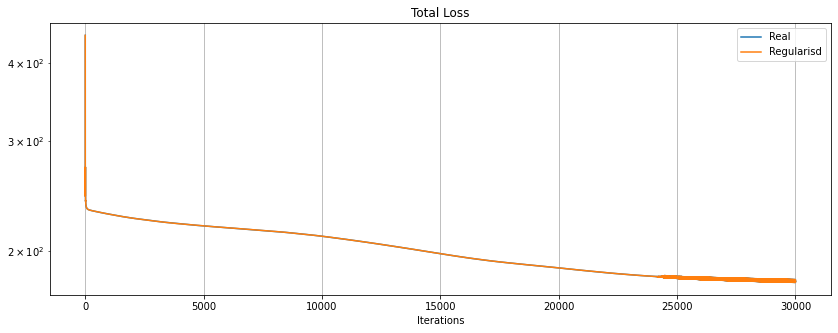

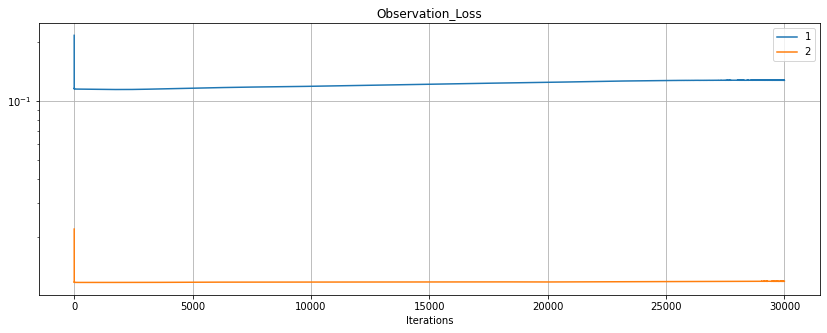

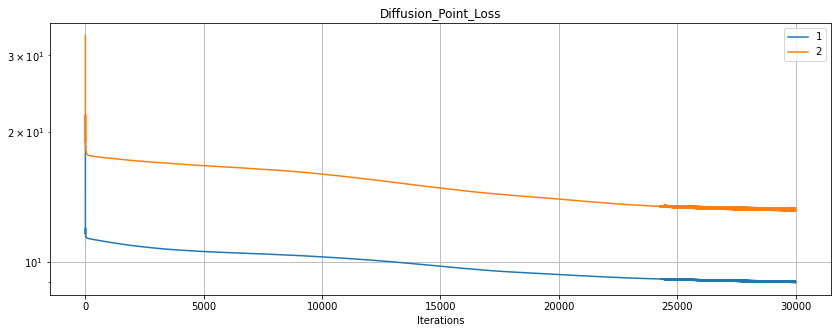

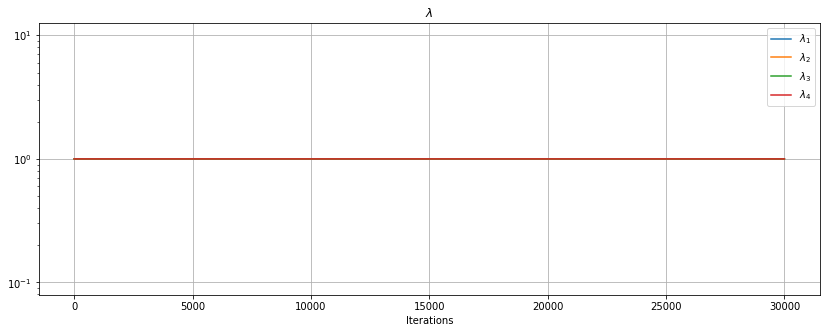

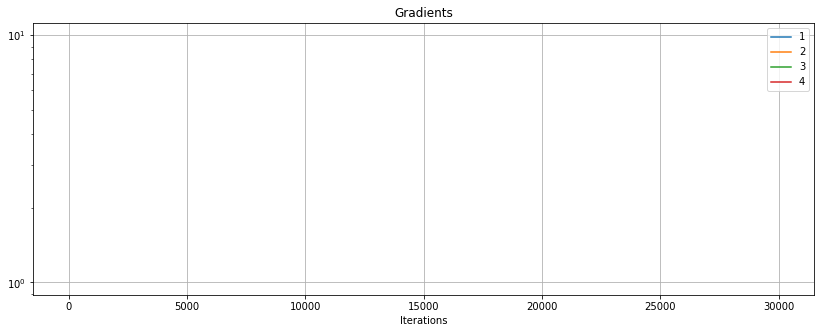

In [49]:
plot_result(merge_dict(results_2_4), model2, start=0, yscale="log")

In [97]:
results_2_5 = model2.train(epochs = 5000+1,
                          batch_size = 384,
                          dataset = ds2,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 198.67133713, total regularise loss: 332.59301758

Observation_Loss ->  (1): 0.11862637  (2): 0.01317613 
Diffusion_Point_Loss ->  (1): 9.72722709  (2): 14.97488725 


lambdas (1): 0.32059491 lambdas (2): 0.00587495 lambdas (3): 2.56775045 lambdas (4): 1.10577977 

Time taken: 0.52s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 197.92525101, total regularise loss: 325.78976440

Observation_Loss ->  (1): 0.11875835  (2): 0.01294022 
Diffusion_Point_Loss ->  (1): 9.70079190  (2): 14.90816534 


lambdas (1): 0.26978186 lambdas (2): 0.00441029 lambdas (3): 2.73464203 lambdas (4): 0.99116552 

Time taken: 14.16s

Start of epoch 200
Training observations acc over epoch: 0.00000000
total loss: 198.27120209, total regularise loss: 339.01217651

Observation_Loss ->  (1): 0.11857219  (2): 0.01237420 
Diffusion_Point_Loss ->  (1): 9.57755220  (2): 15.07540178 


lambdas (1): 0.2579473


Start of epoch 2300
Training observations acc over epoch: 0.00000000
total loss: 178.27266693, total regularise loss: 290.68750000

Observation_Loss ->  (1): 0.12176982  (2): 0.01178491 
Diffusion_Point_Loss ->  (1): 8.78016025  (2): 13.37036824 


lambdas (1): 0.43828899 lambdas (2): 0.00808942 lambdas (3): 2.40304875 lambdas (4): 1.15057302 

Time taken: 13.88s

Start of epoch 2400
Training observations acc over epoch: 0.00000000
total loss: 177.89286232, total regularise loss: 292.99905396

Observation_Loss ->  (1): 0.12187617  (2): 0.01182551 
Diffusion_Point_Loss ->  (1): 8.80228126  (2): 13.30062485 


lambdas (1): 0.51617783 lambdas (2): 0.00879169 lambdas (3): 2.27961564 lambdas (4): 1.19541490 

Time taken: 13.65s

Start of epoch 2500
Training observations acc over epoch: 0.00000000
total loss: 173.22416115, total regularise loss: 286.49353027

Observation_Loss ->  (1): 0.12209388  (2): 0.01185248 
Diffusion_Point_Loss ->  (1): 8.74381691  (2): 12.77525711 


lambdas (1): 0.5


Start of epoch 4600
Training observations acc over epoch: 0.00000000
total loss: 164.03017044, total regularise loss: 266.02337646

Observation_Loss ->  (1): 0.12410770  (2): 0.01181485 
Diffusion_Point_Loss ->  (1): 8.31498915  (2): 12.05285966 


lambdas (1): 0.53623313 lambdas (2): 0.01039177 lambdas (3): 2.25258851 lambdas (4): 1.20078647 

Time taken: 13.81s

Start of epoch 4700
Training observations acc over epoch: 0.00000000
total loss: 164.13693428, total regularise loss: 267.09570312

Observation_Loss ->  (1): 0.12423978  (2): 0.01181719 
Diffusion_Point_Loss ->  (1): 8.31045783  (2): 12.07060206 


lambdas (1): 0.52887493 lambdas (2): 0.01052216 lambdas (3): 2.25353789 lambdas (4): 1.20706522 

Time taken: 13.77s

Start of epoch 4800
Training observations acc over epoch: 0.00000000
total loss: 163.39676666, total regularise loss: 265.26696777

Observation_Loss ->  (1): 0.12432117  (2): 0.01181833 
Diffusion_Point_Loss ->  (1): 8.29792237  (2): 11.99053395 


lambdas (1): 0.5

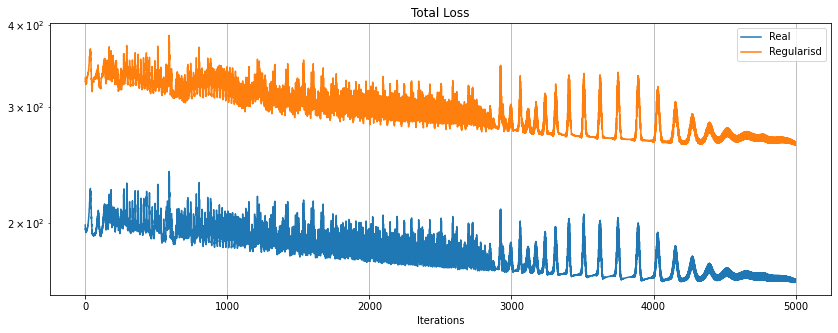

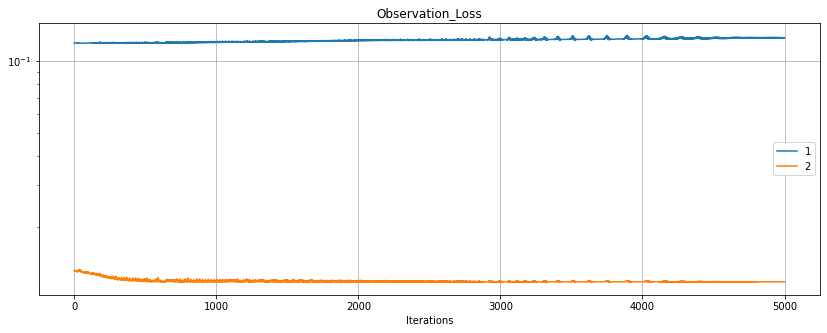

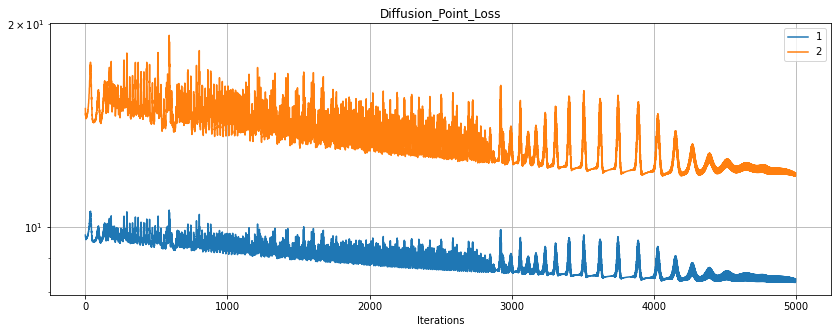

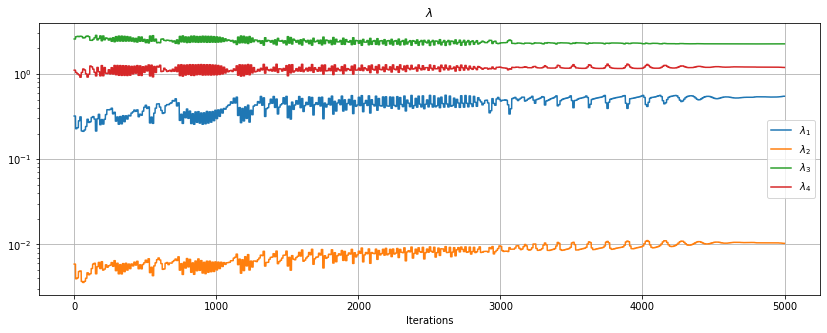

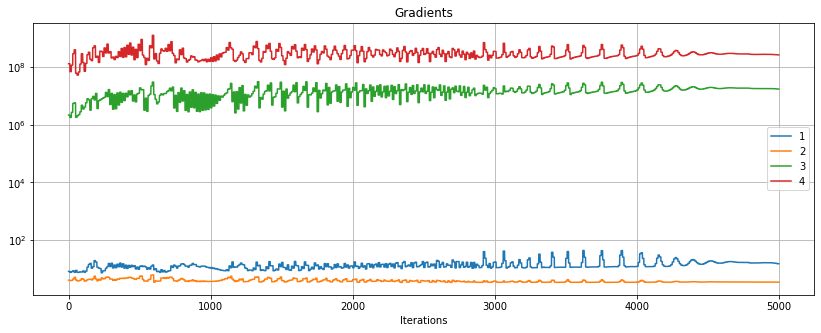

In [98]:
plot_result(merge_dict(results_2_5), model2, start=0, yscale="log")

In [ ]:
model2.optimizer.lr.assign(5e-5)

In [99]:
model2.save(".", "double_pinn_part_two")

In [14]:
model2 = tu.TINN.restore(".", "double_pinn_part_two", ds2)

 from layer0
 to layer4


2022-11-21 18:53:07.669382: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-11-21 18:53:09.729394: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [15]:
pinn2 = model2.pinn
obs_loss = model2.losses[0]
diff_loss_point = model2.losses[1]

In [16]:
lb2 = np.min(dataset2['obs_output'], axis=0)
ub2 = np.max(dataset2['obs_output'], axis=0)

layers3 = [2, 128, 128,  2]
skips3 =   [2, 0,   0,  1]

pinn3 = NN_Compound(pinn2,lb2, ub2, lb, ub, layers3, skips3, dtype=tf.float32)


pde_loss = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn2.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn2.dtype),
                       A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, dataset.simulation.parameters["A"],dtype=pinn.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn2.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

model3 = tu.TINN(pinn3, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  losses= [obs_loss, diff_loss_point, pde_loss], 
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=2e-4),
                  alpha = 0.2, 
                  print_precision=".8f")

In [17]:
384/2

192.0

In [18]:
results_3_1 = model3.train(epochs = 10000+1,
                          batch_size = 192,
                          dataset = ds3,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0
 from layer0
 to layer3
Training observations acc over epoch: 0.00000000
total loss: 198672168.25000000, total regularise loss: 198672160.00000000

Observation_Loss ->  (1): 12.94701558  (2): 4.76716673 
Diffusion_Point_Loss ->  (1): 17028.21002960  (2): 6193112.60546875 
Brusselator ->  (1): 16782.82704926  (2): 6190069.39062500 


lambdas (1): 1.00000000 lambdas (2): 1.00000000 lambdas (3): 1.00000000 lambdas (4): 1.00000000 
lambdas (5): 1.00000000 lambdas (6): 1.00000000 
Time taken: 63.24s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 11655.81103516, total regularise loss: 3032.43872070

Observation_Loss ->  (1): 12.16313630  (2): 4.85144031 
Diffusion_Point_Loss ->  (1): 79.79004025  (2): 359.73520374 
Brusselator ->  (1): 22.11668435  (2): 249.83166599 


lambdas (1): 4.61620569 lambdas (2): 0.39881480 lambdas (3): 0.73907512 lambdas (4): 0.12050011 
lambdas (5): 0.06593952 lambdas (6): 0.05946463 
Time taken: 72.86s

Start of


Start of epoch 1800
Training observations acc over epoch: 0.00000000
total loss: 4168.86212158, total regularise loss: 1641.84912109

Observation_Loss ->  (1): 11.29949719  (2): 1.87536322 
Diffusion_Point_Loss ->  (1): 53.78827858  (2): 138.87658024 
Brusselator ->  (1): 19.53288007  (2): 35.18128860 


lambdas (1): 5.13796520 lambdas (2): 0.07922780 lambdas (3): 0.67976487 lambdas (4): 0.03652103 
lambdas (5): 0.06429142 lambdas (6): 0.00222980 
Time taken: 43.10s

Start of epoch 1900
Training observations acc over epoch: 0.00000000
total loss: 4391.47950745, total regularise loss: 2471.56567383

Observation_Loss ->  (1): 11.45578337  (2): 2.12747703 
Diffusion_Point_Loss ->  (1): 53.97384214  (2): 155.06847095 
Brusselator ->  (1): 10.53534937  (2): 41.30654770 


lambdas (1): 4.75428057 lambdas (2): 0.10131530 lambdas (3): 0.92189598 lambdas (4): 0.11674327 
lambdas (5): 0.02746938 lambdas (6): 0.07829552 
Time taken: 45.22s

Start of epoch 2000
Training observations acc over epoc


Start of epoch 3600
Training observations acc over epoch: 0.00000000
total loss: 3822.19795227, total regularise loss: 1773.72546387

Observation_Loss ->  (1): 11.28921175  (2): 2.00355434 
Diffusion_Point_Loss ->  (1): 53.81001568  (2): 127.40813398 
Brusselator ->  (1): 19.90921199  (2): 24.46724033 


lambdas (1): 5.13596964 lambdas (2): 0.07944489 lambdas (3): 0.52900350 lambdas (4): 0.18974638 
lambdas (5): 0.05980719 lambdas (6): 0.00602824 
Time taken: 45.06s

Start of epoch 3700
Training observations acc over epoch: 0.00000000
total loss: 4833.28126526, total regularise loss: 2734.67895508

Observation_Loss ->  (1): 11.32179034  (2): 1.89748816 
Diffusion_Point_Loss ->  (1): 54.31377625  (2): 160.92874670 
Brusselator ->  (1): 18.92537558  (2): 54.69289875 


lambdas (1): 5.33573198 lambdas (2): 0.07631925 lambdas (3): 0.41428661 lambdas (4): 0.12764357 
lambdas (5): 0.04094501 lambdas (6): 0.00507413 
Time taken: 45.50s

Start of epoch 3800
Training observations acc over epoc


Start of epoch 5400
Training observations acc over epoch: 0.00000000
total loss: 3656.96644592, total regularise loss: 2417.32250977

Observation_Loss ->  (1): 11.36783886  (2): 1.96563204 
Diffusion_Point_Loss ->  (1): 53.90293121  (2): 127.10363293 
Brusselator ->  (1): 14.74151200  (2): 19.47885680 


lambdas (1): 4.98896885 lambdas (2): 0.07229500 lambdas (3): 0.56618518 lambdas (4): 0.32210031 
lambdas (5): 0.04384457 lambdas (6): 0.00660650 
Time taken: 44.42s

Start of epoch 5500
Training observations acc over epoch: 0.00000000
total loss: 3830.52659607, total regularise loss: 1841.98254395

Observation_Loss ->  (1): 11.28143632  (2): 2.07377798 
Diffusion_Point_Loss ->  (1): 53.83968425  (2): 127.31362200 
Brusselator ->  (1): 20.28144073  (2): 24.61794984 


lambdas (1): 5.15589094 lambdas (2): 0.07278495 lambdas (3): 0.51946044 lambdas (4): 0.18442729 
lambdas (5): 0.06128869 lambdas (6): 0.00614831 
Time taken: 45.02s

Start of epoch 5600
Training observations acc over epoc


Start of epoch 7200
Training observations acc over epoch: 0.00000000
total loss: 4340.54412842, total regularise loss: 2066.55590820

Observation_Loss ->  (1): 11.29265141  (2): 2.31026764 
Diffusion_Point_Loss ->  (1): 53.64455795  (2): 143.51511192 
Brusselator ->  (1): 19.22513866  (2): 41.29628205 


lambdas (1): 5.08725786 lambdas (2): 0.07734789 lambdas (3): 0.66482121 lambdas (4): 0.09821962 
lambdas (5): 0.06767972 lambdas (6): 0.00467350 
Time taken: 44.94s

Start of epoch 7300
Training observations acc over epoch: 0.00000000
total loss: 3883.80851746, total regularise loss: 1726.00964355

Observation_Loss ->  (1): 11.27238840  (2): 2.30226213 
Diffusion_Point_Loss ->  (1): 53.87503839  (2): 128.50863123 
Brusselator ->  (1): 20.76552117  (2): 26.01419282 


lambdas (1): 5.20469809 lambdas (2): 0.07631538 lambdas (3): 0.51587856 lambdas (4): 0.13253556 
lambdas (5): 0.06548282 lambdas (6): 0.00508979 
Time taken: 44.73s

Start of epoch 7400
Training observations acc over epoc


Start of epoch 9000
Training observations acc over epoch: 0.00000000
total loss: 3758.59439087, total regularise loss: 2461.86083984

Observation_Loss ->  (1): 11.32672131  (2): 2.33916645 
Diffusion_Point_Loss ->  (1): 53.97552085  (2): 128.38391066 
Brusselator ->  (1): 17.21336102  (2): 21.67347300 


lambdas (1): 4.78089714 lambdas (2): 0.07053454 lambdas (3): 0.71135396 lambdas (4): 0.37530988 
lambdas (5): 0.05338159 lambdas (6): 0.00852291 
Time taken: 44.63s

Start of epoch 9100
Training observations acc over epoch: 0.00000000
total loss: 3862.05796814, total regularise loss: 1904.14270020

Observation_Loss ->  (1): 11.28104258  (2): 2.33264005 
Diffusion_Point_Loss ->  (1): 53.82510877  (2): 128.85037136 
Brusselator ->  (1): 20.09740293  (2): 24.99205720 


lambdas (1): 5.04478407 lambdas (2): 0.06820423 lambdas (3): 0.63304871 lambdas (4): 0.17848420 
lambdas (5): 0.06934809 lambdas (6): 0.00613114 
Time taken: 43.93s

Start of epoch 9200
Training observations acc over epoc

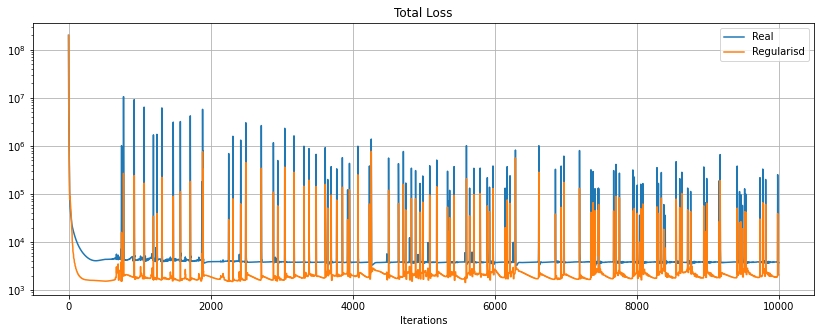

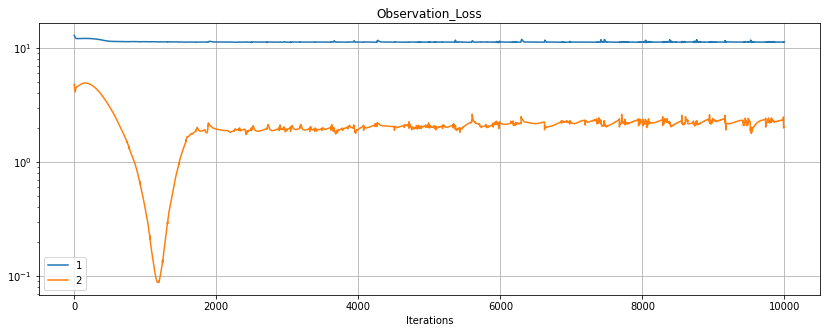

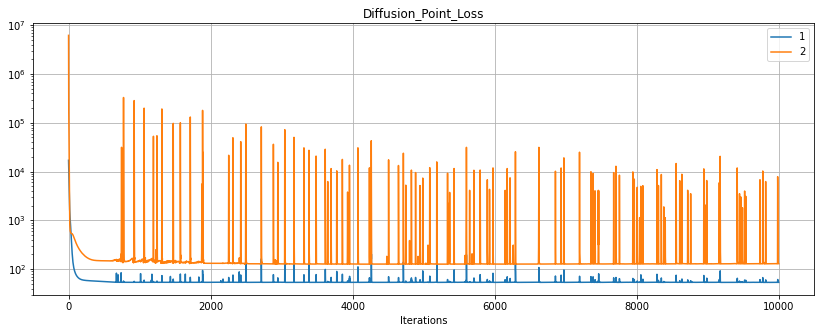

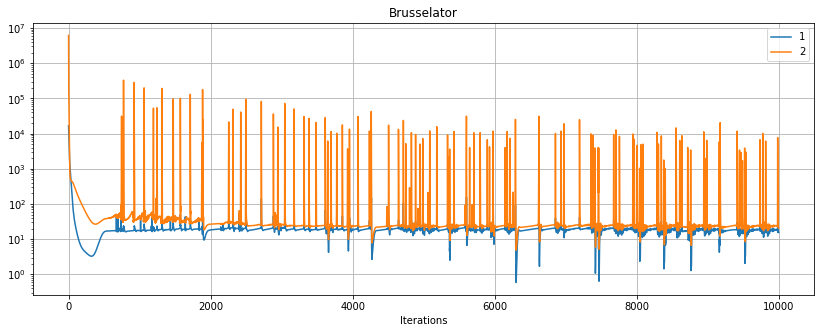

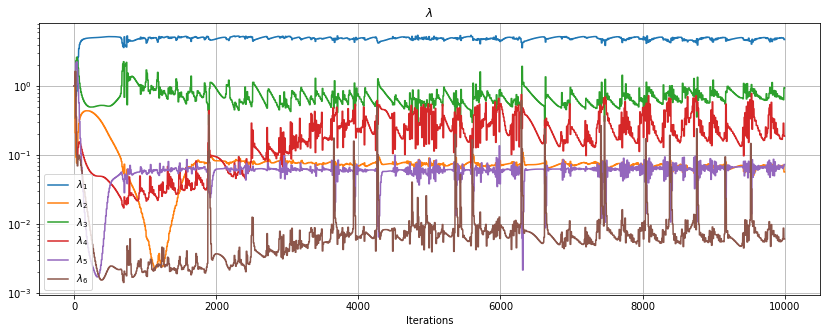

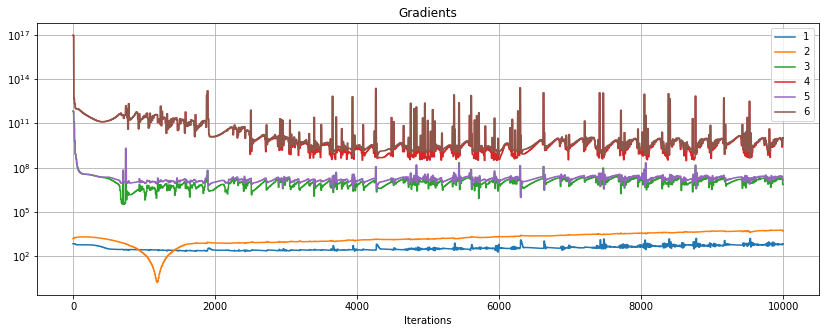

In [19]:
plot_result(merge_dict(results_3_1), model3, start=0, yscale="log")

In [21]:
model3.optimizer.lr.assign(5e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=5e-05>

In [24]:
results_3_2 = model3.train(epochs = 1000+1,
                          batch_size = 192,
                          dataset = ds3,
                          print_interval=100,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=10)


Start of epoch 0
Training observations acc over epoch: 0.00000000
total loss: 3672.27041626, total regularise loss: 2115.62304688

Observation_Loss ->  (1): 11.31551319  (2): 2.11933425 
Diffusion_Point_Loss ->  (1): 51.26027155  (2): 128.49847031 
Brusselator ->  (1): 15.03209358  (2): 21.29121697 


lambdas (1): 4.52902126 lambdas (2): 0.06133191 lambdas (3): 1.19755816 lambdas (4): 0.14320248 
lambdas (5): 0.06500383 lambdas (6): 0.00388218 
Time taken: 1.26s

Start of epoch 100
Training observations acc over epoch: 0.00000000
total loss: 4984.12451172, total regularise loss: 2392.49511719

Observation_Loss ->  (1): 11.29058295  (2): 2.08519382 
Diffusion_Point_Loss ->  (1): 50.49487758  (2): 169.52654028 
Brusselator ->  (1): 15.63534057  (2): 62.47524881 


lambdas (1): 4.77475357 lambdas (2): 0.06326181 lambdas (3): 1.00654304 lambdas (4): 0.08036728 
lambdas (5): 0.06842717 lambdas (6): 0.00664764 
Time taken: 32.96s

Start of epoch 200
Training observations acc over epoch: 0.0

In [25]:
model3.save(".", "double_pinn_part_three_lr_5_e_5")

In [13]:
optimizer=keras.optimizers.Adam(learning_rate=5e-4)

In [18]:
@tf.function
def train_step(pinn, loss,  Y, norm, optimizer):
    with tf.GradientTape(persistent=True) as tape:
        outputs, fu, fv = loss.residual(pinn, 0)        
        loss_obs = norm.norm(Y - outputs)
        loss_res_u = norm.norm(fu)
        loss_res_v = norm.norm(fv)
        loss_value = loss_obs #+ loss_res_u + loss_res_v
        trainables = pinn.trainable_variables + loss.trainables()
    grads = tape.gradient(loss_value, trainables)
    optimizer.apply_gradients(zip(grads, trainables))
    return loss_value, loss_obs, loss_res_u, loss_res_v
    

In [20]:
#ds = [data[..., t].reshape(data.shape[0],data.shape[1]*data.shape[2]) for t in range(data.shape[3])]
#ds = np.concatenate(ds, axis=1).T
ds = np.array([data[c,...].reshape(data.shape[1]*data.shape[2]*data.shape[3]) for c in range(data.shape[0])]).T

In [21]:
ds.shape

(30000, 2)

In [ ]:
l = np.array([train_step(pinn, pde_loss, ds, l2_norm+l_inf_norm, optimizer) for epoch in range(100)])

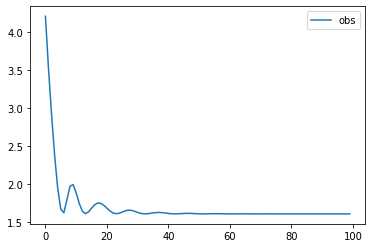

In [85]:
#plt.plot(l[:,0], label="total")
plt.plot(l[:,1], label="obs")
#plt.plot(l[:,2], label="res u")
#plt.plot(l[:,3], label="res v")
plt.legend()
#plt.yscale('log')

In [65]:
optimizer.lr.assign(1e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-04>

In [66]:
l2 = np.array([train_step(pinn, pde_loss, ds, l2_norm, optimizer) for epoch in range(100)])

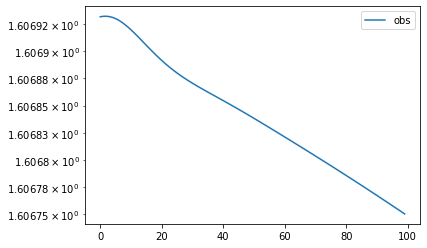

In [67]:
#plt.plot(l2[:,0], label="total")
plt.plot(l2[:,1], label="obs")
#plt.plot(l2[:,2], label="res u")
#plt.plot(l2[:,3], label="res v")
plt.legend()
plt.yscale('log')

In [79]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

#A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
#B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

128.0


In [112]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)

In [100]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
#output_test = pinn(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
#output_test = pinn.net(0)
#output_test = output_test[:, 1].numpy().reshape((2, x_size, y_size))
#output_test = np.array([ output_test[:, i].numpy()[::len(t_star)].reshape((x_size, y_size)) for i in range(2)]) 
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [81]:
@tf.function
def derivatives(pinn, x):
    return diff_loss_point.derivatives(pinn, x)

In [101]:
test_d = np.vstack([XX_test, YY_test, TT_test]).T.astype(np.float32)
y, u, u_t, u_xx, u_yy, v, v_t, v_xx, v_yy = derivatives(pinn2, test_d)
D_u = simulation.Ds[0]
D_v = simulation.Ds[1]

In [102]:
diffusion_u = D_u * (u_xx + u_yy)
diffusion_v = D_v * (v_xx + v_yy)

dxdy = np.prod(simulation.n)/np.prod(simulation.L)
diffusion_u_space = D_u * dxdy * diffusion(simulation.n, u.numpy().reshape(x_size, y_size))
diffusion_v_space = D_v * dxdy * diffusion(simulation.n, v.numpy().reshape(x_size, y_size))

In [103]:
output_test.shape

(2, 32, 32)

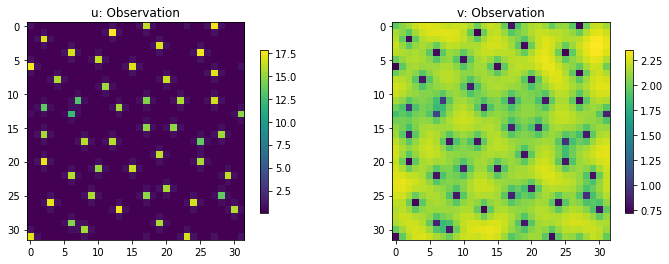

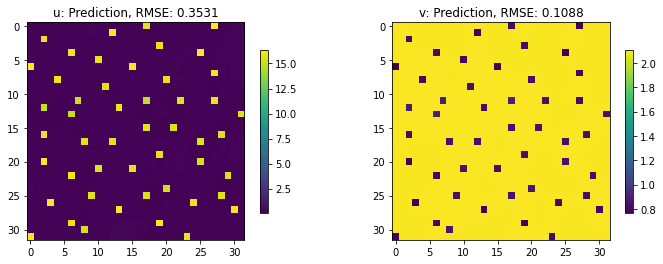

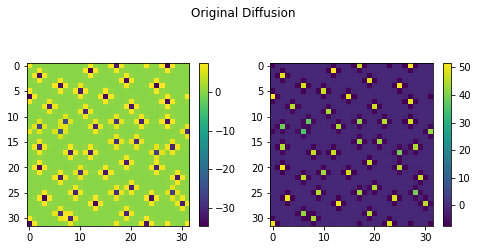

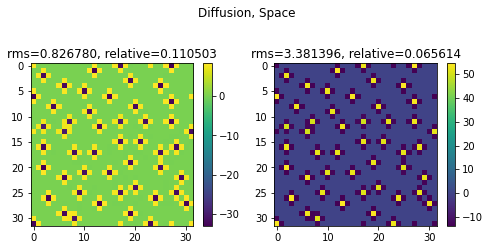

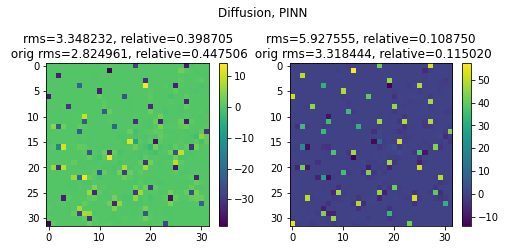

In [104]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Original Diffusion")
plt.subplot(121)
plt.imshow(diff_Y[0, :, :, T_test_index])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(diff_Y[1, :, :, T_test_index])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, Space")
plt.subplot(121)
rms = np.sqrt(np.mean((diff_Y[0, :, :, T_test_index]-diffusion_u_space)**2))
relative_rms = rms/np.max(diff_Y[0, :, :, T_test_index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_u_space)
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diff_Y[1, :, :, T_test_index]-diffusion_v_space)**2))
relative_rms = rms/np.max(diff_Y[1, :, :, T_test_index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}")
plt.imshow(diffusion_v_space)
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.suptitle("Diffusion, PINN")
plt.subplot(121)
rms = np.sqrt(np.mean((diffusion_u.numpy().reshape(x_size, y_size)-diffusion_u_space)**2))
relative_rms = rms/np.max(diffusion_u_space)
rms2 = np.sqrt(np.mean((diff_Y[0, :, :, T_test_index]-diffusion_u.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[0, :, :, T_test_index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_u.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.subplot(122)
rms = np.sqrt(np.mean((diffusion_v.numpy().reshape(x_size, y_size)-diffusion_v_space)**2))
relative_rms = rms/np.max(diffusion_v_space)
rms2 = np.sqrt(np.mean((diff_Y[1, :, :, T_test_index]-diffusion_v.numpy().reshape(x_size, y_size))**2))
relative_rms2 = rms/np.max(diff_Y[1, :, :, T_test_index])
plt.title(f"rms={rms:.6f}, relative={relative_rms:.6f}\n orig rms={rms2:.6f}, relative={relative_rms2:.6f}")
plt.imshow(diffusion_v.numpy().reshape(x_size, y_size))
plt.colorbar(shrink=.75)
plt.show()

In [53]:
#test_d = np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T
test_d = np.vstack([XX_test, YY_test, TT_test]).T
test_outputs = np.zeros((test_d.shape[0], len(node_names)))
test_pde_u = np.zeros(test_d.shape[0])
test_pde_v = np.zeros(test_d.shape[0])

for i, _ in enumerate(test_d):
    outs, pde_u, pde_v = pde_loss.residual(pinn, test_d[i:(i+1), ...])
    test_outputs[i] = outs.numpy()
    test_pde_u[i] = pde_u.numpy()
    test_pde_v[i] = pde_v.numpy()


In [54]:
test_outputs = np.array([ test_outputs[:, i].reshape((x_size, y_size)) for i in range(test_outputs.shape[1])]) 
test_pde_u = test_pde_u.reshape((x_size, y_size))
test_pde_v = test_pde_v.reshape((x_size, y_size))

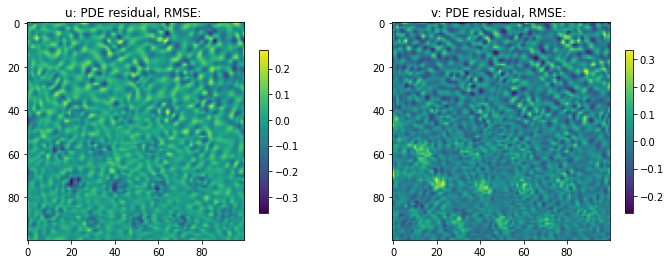

In [55]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

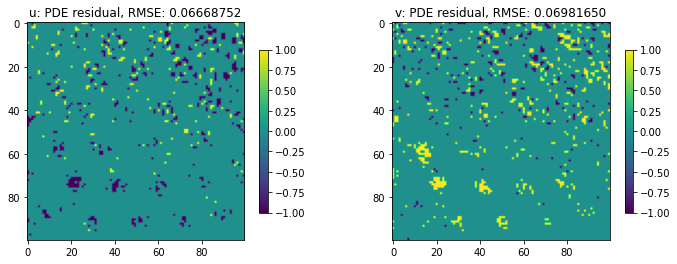

In [58]:
max_L = .12
min_L = -.12

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Parameters estimation

In [2]:
import os

In [3]:
dataset = TINN_Single_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_32_by_32/Brusselator_2"),
                                 "Brusselator_2",
                                 thining_start=-2)

In [4]:
#layers = [5, 128, 128, 128, 128, 2]
#layers = [3, 256, 256, 256, 256, 2]
layers = [3, 512, 512, 128, 128, 128, 128, 128, 128, 128, 128, 128, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn2 = tu.Res_NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss2 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulation.Ds[0],dtype=pinn2.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulation.Ds[1],dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn2.dtype),
                       A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn2.dtype)
                       B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn2.dtype) 
                       #B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm2 = L2()
l_inf_norm2 = L_Inf()

In [5]:
optimizer2=keras.optimizers.Adam(learning_rate=1e-4)

In [6]:
model2 = tu.TINN(pinn2, 
                pde_loss2, 
                loss = l2_norm2+ l_inf_norm2,
                #non_zero_loss=pde_non_zero, 
                optimizer=optimizer2,
                alpha = 0.2,
                loss_penalty_power=1,
                print_precision=".10f")

In [7]:
dataset.x_size

2048

In [8]:
results2_1 = model2.train(epochs=10000+1,
                      batch_size=dataset.x_size//4,
                      dataset=dataset,
                      print_interval=500,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval=10,
                     )


Start of epoch 0
Training observations acc over epoch: 8.2414741516
total loss: 35.6523337882, total regularisd loss (sum of batches): 142.6093351528
obs u loss: 24.4641886594, obs v loss: 8.5017080207
pde u loss: 2.1984550136, pde v loss: 0.4879820945
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000
A: 0.99966 B: 0.99964 
Time taken: 118.02s

Start of epoch 500
Training observations acc over epoch: 5.6929974556
total loss: 23.7908447725, total regularisd loss (sum of batches): 351.7908618892
obs u loss: 22.2791210349, obs v loss: 0.4928696028
pde u loss: 0.6635467127, pde v loss: 0.3553074220
lambda obs u: 3.9462373326, lambda obs v: 0.0305182693
lambda pde u: 0.0141628487, lambda pde v: 0.0090815494
A: 0.96845 B: 1.05566 
Time taken: 680.49s

Start of epoch 1000
Training observations acc over epoch: 5.6633186340
total loss: 23.4456965635, total regularisd loss (sum of batches): 349.0874498014
obs u loss: 22.2292415122, obs


Start of epoch 9500
Training observations acc over epoch: 2.5630888939
total loss: 19.5244553711, total regularisd loss (sum of batches): 119.0811976157
obs u loss: 9.7834065469, obs v loss: 0.4689490534
pde u loss: 4.8836765086, pde v loss: 4.3884232622
lambda obs u: 2.9513168800, lambda obs v: 0.7362415767
lambda pde u: 0.1749861594, lambda pde v: 0.1374553840
A: 0.02293 B: 2.34246 
Time taken: 614.66s

Start of epoch 10000
Training observations acc over epoch: 2.1955780983
total loss: 22.5859824235, total regularisd loss (sum of batches): 112.7641862575
obs u loss: 8.1990224244, obs v loss: 0.5832900010
pde u loss: 7.2782335326, pde v loss: 6.5254364655
lambda obs u: 2.8374981489, lambda obs v: 0.6894057359
lambda pde u: 0.3265984103, lambda pde v: 0.1464977049
A: 0.05008 B: 2.34923 
Time taken: 618.41s


In [ ]:
plot_result(results2_1, param_names=["A", "B"])

In [ ]:
print(f"A = {pde_loss2.A.tf_var.numpy()[0]:.16f}")
print(f"B = {pde_loss2.B.tf_var.numpy()[0]:.16f}")

In [ ]:
dataset.simulation.parameters

In [21]:
x_domain = dataset.simulation.L[0] * np.linspace(0, 1, dataset.simulation.n[0])
y_domain = dataset.simulation.L[1] * np.linspace(0, 1, dataset.simulation.n[1])
x_size = dataset.simulation.n[0]
y_size = dataset.simulation.n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ts[T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ts[T_test_index], N2)  # 1 x N2

A_test = np.repeat(dataset.simulation.parameters["A"]+1, N2)
B_test = np.repeat(dataset.simulation.parameters["B"]+1, N2)

128.0


In [22]:
output_test = pinn2(np.vstack([XX_test, YY_test, TT_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

In [23]:
import os
data_path = os.path.abspath("../../test/outputs_Brusselator_100_by_100/Brusselator_1/Brusselator_1.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data = data[...,-2:]

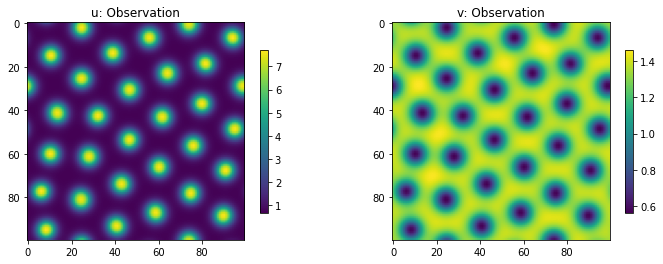

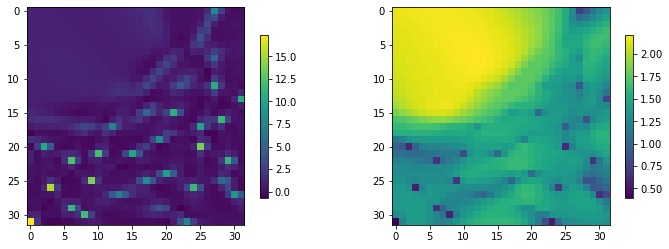

In [24]:
node_names = ["u", "v"]
_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    plt.title(f"{name}: Observation")
    plt.imshow(data[i,:, :, T_test_index])
    plt.colorbar(shrink=.75)

plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    #rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    #plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [30]:
test_outputs, test_pde_u, test_pde_v = pde_loss2.residual(pinn2, np.vstack([XX_test, YY_test, TT_test]).T)
test_outputs = test_outputs.numpy()
test_pde_u = test_pde_u.numpy().reshape((x_size, y_size))
test_pde_v = test_pde_v.numpy().reshape((x_size, y_size))

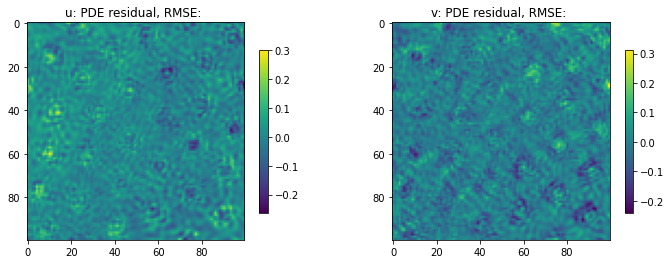

In [32]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title(f"u: PDE residual, RMSE: ")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
plt.title(f"v: PDE residual, RMSE: ")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

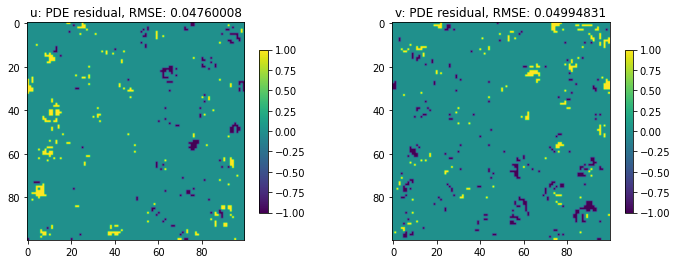

In [33]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()

# Parameters as input

In [2]:
import os
dataset = TINN_Multiple_Sim_Dataset(os.path.abspath("../../test/outputs_Brusselator_100_by_100_dense"),
                                 ["Brusselator_1"] +
                                 [f"Brusselator_1_{id}" for id in range(1,61)],
                                 param_names = ["A", "B"],
                                 pde_ratio = 0,
                                 thining_start=-2)

In [3]:
dataset.x_size

1220000

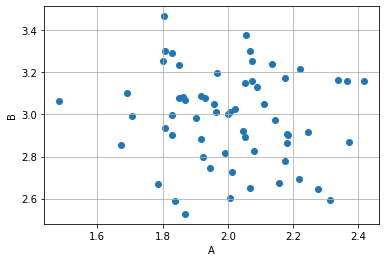

In [4]:
As = [s.parameters["A"] for s in dataset.simulations]
Bs = [s.parameters["B"] for s in dataset.simulations]
plt.scatter(As, Bs)
plt.xlabel("A")
plt.ylabel("B")
plt.grid()
plt.show()

In [5]:
#layers = [5, 128, 128, 128, 128, 2]
layers = [5, 256, 256, 256, 256, 2]
#layers = [5, 512, 512, 512, 512, 2]

#lb = np.concatenate([lb, [0, 0]])
#ub = np.concatenate([ub, [2.0, 2.0]])
pinn3 = tu.NN(layers, dataset.lb, dataset.ub, dtype=tf.float64)
pde_loss3 = Brusselator(D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, dataset.simulations[0].Ds[0],dtype=pinn3.dtype),
                       D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, dataset.simulations[0].Ds[1],dtype=pinn3.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.CONSTANT, dataset.simulation.parameters["A"],dtype=pinn3.dtype),
                       #A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinn3.dtype),
                       A=PDE_Parameter("A", Parameter_Type.INPUT, index=0),
                       #B=PDE_Parameter("B", Parameter_Type.CONSTANT, dataset.simulation.parameters["B"],dtype=pinn3.dtype)
                       #B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinn3.dtype) 
                       B=PDE_Parameter("B", Parameter_Type.INPUT, index=1)
                      )

l2_norm3 = L2()
l_inf_norm3 = L_Inf()

In [6]:
model3 = tu.TINN(pinn3, 
                pde_loss3, 
                loss = l2_norm3+ l_inf_norm3,
                #non_zero_loss=pde_non_zero, 
                alpha = 0.2,
                loss_penalty_power=1,
                print_precision=".10f")

In [7]:
dataset = dataset.cache()

In [8]:
results3_1 = model3.train(epochs=2000+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0


2022-10-25 16:54:14.289397: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-25 16:54:26.950497: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


Training observations acc over epoch: 1.6530870199
total loss: 6.9169794368, total regularisd loss (sum of batches): 2636.0631352606
obs u loss: 6.3364546754, obs v loss: 0.2758937765
pde u loss: 0.1407621626, pde v loss: 0.1638688222
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 151.47s

Start of epoch 10
Training observations acc over epoch: 1.5920084715
total loss: 6.3995398850, total regularisd loss (sum of batches): 2439.3650864083
obs u loss: 6.1481721523, obs v loss: 0.2198615170
pde u loss: 0.0215402650, pde v loss: 0.0099659507
lambda obs u: 1.0000000000, lambda obs v: 1.0000000000
lambda pde u: 1.0000000000, lambda pde v: 1.0000000000

Time taken: 317.21s

Start of epoch 20
Training observations acc over epoch: 1.5918910503
total loss: 6.3964524928, total regularisd loss (sum of batches): 2438.1937210718
obs u loss: 6.1475305056, obs v loss: 0.2200321439
pde u loss: 0.0202191470, pde v loss: 0.008670


Start of epoch 220
Training observations acc over epoch: 0.1004494280
total loss: 1.9002548007, total regularisd loss (sum of batches): 480.4835425997
obs u loss: 0.3300951770, obs v loss: 0.0717026496
pde u loss: 0.7611256117, pde v loss: 0.7373313625
lambda obs u: 1.9913089330, lambda obs v: 1.3443700484
lambda pde u: 0.3173374009, lambda pde v: 0.3469836177

Time taken: 394.59s

Start of epoch 230
Training observations acc over epoch: 0.0972554460
total loss: 1.8379153961, total regularisd loss (sum of batches): 460.9317989861
obs u loss: 0.3192731234, obs v loss: 0.0697486675
pde u loss: 0.7309814705, pde v loss: 0.7179121346
lambda obs u: 1.9913089330, lambda obs v: 1.3443700484
lambda pde u: 0.3173374009, lambda pde v: 0.3469836177

Time taken: 311.70s

Start of epoch 240
Training observations acc over epoch: 0.0939480960
total loss: 1.7923214690, total regularisd loss (sum of batches): 447.0453345112
obs u loss: 0.3070504384, obs v loss: 0.0687419320
pde u loss: 0.7164480774, p


Start of epoch 440
Training observations acc over epoch: 0.0658497214
total loss: 1.2543070838, total regularisd loss (sum of batches): 295.8402871995
obs u loss: 0.2138059572, obs v loss: 0.0495929763
pde u loss: 0.4871784499, pde v loss: 0.5037297004
lambda obs u: 1.7441097607, lambda obs v: 1.6046013562
lambda pde u: 0.3302311975, lambda pde v: 0.3210576856

Time taken: 394.61s

Start of epoch 450
Training observations acc over epoch: 0.0652208701
total loss: 1.2427952027, total regularisd loss (sum of batches): 292.2581465893
obs u loss: 0.2119532768, obs v loss: 0.0489302329
pde u loss: 0.4826421902, pde v loss: 0.4992695028
lambda obs u: 1.7441097607, lambda obs v: 1.6046013562
lambda pde u: 0.3302311975, lambda pde v: 0.3210576856

Time taken: 311.65s

Start of epoch 460
Training observations acc over epoch: 0.0647840127
total loss: 1.2418534768, total regularisd loss (sum of batches): 291.2249851964
obs u loss: 0.2106797370, obs v loss: 0.0484562630
pde u loss: 0.4817046914, p


Start of epoch 660
Training observations acc over epoch: 0.0561888367
total loss: 1.0174607997, total regularisd loss (sum of batches): 236.1266280370
obs u loss: 0.1859758418, obs v loss: 0.0387795000
pde u loss: 0.3823813609, pde v loss: 0.4103240970
lambda obs u: 1.5446244141, lambda obs v: 1.7948740021
lambda pde u: 0.3437117376, lambda pde v: 0.3167898462

Time taken: 394.57s

Start of epoch 670
Training observations acc over epoch: 0.0560807511
total loss: 1.0058793401, total regularisd loss (sum of batches): 233.6032099734
obs u loss: 0.1859717676, obs v loss: 0.0383512080
pde u loss: 0.3767449392, pde v loss: 0.4048114254
lambda obs u: 1.5446244141, lambda obs v: 1.7948740021
lambda pde u: 0.3437117376, lambda pde v: 0.3167898462

Time taken: 311.60s

Start of epoch 680
Training observations acc over epoch: 0.0558536425
total loss: 1.0031872503, total regularisd loss (sum of batches): 232.8038092963
obs u loss: 0.1853455389, obs v loss: 0.0380690029
pde u loss: 0.3756860046, p


Start of epoch 880
Training observations acc over epoch: 0.0514696464
total loss: 0.8894505057, total regularisd loss (sum of batches): 202.8654519637
obs u loss: 0.1742257806, obs v loss: 0.0316528194
pde u loss: 0.3242585726, pde v loss: 0.3593133331
lambda obs u: 1.3557135715, lambda obs v: 1.9850231100
lambda pde u: 0.3547692669, lambda pde v: 0.3044940515

Time taken: 394.62s

Start of epoch 890
Training observations acc over epoch: 0.0512904339
total loss: 0.8804311046, total regularisd loss (sum of batches): 197.5671903454
obs u loss: 0.1743230075, obs v loss: 0.0308386091
pde u loss: 0.3176413752, pde v loss: 0.3576281129
lambda obs u: 1.3557135715, lambda obs v: 1.9850231100
lambda pde u: 0.3547692669, lambda pde v: 0.3044940515

Time taken: 311.80s

Start of epoch 900
Training observations acc over epoch: 0.0514472835
total loss: 0.8896521595, total regularisd loss (sum of batches): 198.8646825162
obs u loss: 0.1751968424, obs v loss: 0.0305923015
pde u loss: 0.3202554189, p


Start of epoch 1100
Training observations acc over epoch: 0.0477724373
total loss: 0.8003582203, total regularisd loss (sum of batches): 178.9733392156
obs u loss: 0.1641161336, obs v loss: 0.0269736955
pde u loss: 0.2880082373, pde v loss: 0.3212601540
lambda obs u: 1.3139670495, lambda obs v: 2.0291124653
lambda pde u: 0.3506269945, lambda pde v: 0.3062934908

Time taken: 394.51s

Start of epoch 1110
Training observations acc over epoch: 0.0475688428
total loss: 0.7983455372, total regularisd loss (sum of batches): 178.1628841155
obs u loss: 0.1634468951, obs v loss: 0.0268284586
pde u loss: 0.2869519171, pde v loss: 0.3211182663
lambda obs u: 1.3139670495, lambda obs v: 2.0291124653
lambda pde u: 0.3506269945, lambda pde v: 0.3062934908

Time taken: 311.66s

Start of epoch 1120
Training observations acc over epoch: 0.0474360101
total loss: 0.7964283105, total regularisd loss (sum of batches): 177.7053861763
obs u loss: 0.1630777693, obs v loss: 0.0266661796
pde u loss: 0.2865030301


Start of epoch 1320
Training observations acc over epoch: 0.0455110148
total loss: 0.7538807050, total regularisd loss (sum of batches): 155.7127477386
obs u loss: 0.1598271535, obs v loss: 0.0222169103
pde u loss: 0.2635596888, pde v loss: 0.3082769525
lambda obs u: 1.1608630604, lambda obs v: 2.2118124607
lambda pde u: 0.3428496535, lambda pde v: 0.2844748254

Time taken: 394.48s

Start of epoch 1330
Training observations acc over epoch: 0.0448879078
total loss: 0.7387774338, total regularisd loss (sum of batches): 154.5396627040
obs u loss: 0.1573802909, obs v loss: 0.0221713188
pde u loss: 0.2588372560, pde v loss: 0.3003885680
lambda obs u: 1.1608630604, lambda obs v: 2.2118124607
lambda pde u: 0.3428496535, lambda pde v: 0.2844748254

Time taken: 311.58s

Start of epoch 1340
Training observations acc over epoch: 0.0445171669
total loss: 0.7253139308, total regularisd loss (sum of batches): 152.3820484406
obs u loss: 0.1560130776, obs v loss: 0.0220555801
pde u loss: 0.2539548378


Start of epoch 1540
Training observations acc over epoch: 0.0426075123
total loss: 0.6908485049, total regularisd loss (sum of batches): 145.6772664575
obs u loss: 0.1511126833, obs v loss: 0.0193173818
pde u loss: 0.2408860269, pde v loss: 0.2795324128
lambda obs u: 1.1053658092, lambda obs v: 2.2658029958
lambda pde u: 0.3477715962, lambda pde v: 0.2810595988

Time taken: 394.54s

Start of epoch 1550
Training observations acc over epoch: 0.0420685150
total loss: 0.6790270362, total regularisd loss (sum of batches): 139.7365763114
obs u loss: 0.1495056483, obs v loss: 0.0187683683
pde u loss: 0.2357664177, pde v loss: 0.2749866019
lambda obs u: 1.1053658092, lambda obs v: 2.2658029958
lambda pde u: 0.3477715962, lambda pde v: 0.2810595988

Time taken: 311.59s

Start of epoch 1560
Training observations acc over epoch: 0.0414840579
total loss: 0.6594580196, total regularisd loss (sum of batches): 136.5948282557
obs u loss: 0.1473855009, obs v loss: 0.0185506702
pde u loss: 0.2283523759


Start of epoch 1760
Training observations acc over epoch: 0.0393189341
total loss: 0.6250674107, total regularisd loss (sum of batches): 123.7238082992
obs u loss: 0.1415296629, obs v loss: 0.0157460922
pde u loss: 0.2154790040, pde v loss: 0.2523126515
lambda obs u: 1.0544107124, lambda obs v: 2.3287526646
lambda pde u: 0.3435426188, lambda pde v: 0.2732940041

Time taken: 394.55s

Start of epoch 1770
Training observations acc over epoch: 0.0391497463
total loss: 0.6229552947, total regularisd loss (sum of batches): 124.7181565792
obs u loss: 0.1408568058, obs v loss: 0.0157422266
pde u loss: 0.2151681511, pde v loss: 0.2511881112
lambda obs u: 1.0544107124, lambda obs v: 2.3287526646
lambda pde u: 0.3435426188, lambda pde v: 0.2732940041

Time taken: 311.63s

Start of epoch 1780
Training observations acc over epoch: 0.0389567055
total loss: 0.6204336963, total regularisd loss (sum of batches): 124.1473496880
obs u loss: 0.1402213753, obs v loss: 0.0156055217
pde u loss: 0.2145223684


Start of epoch 1980
Training observations acc over epoch: 0.0351502448
total loss: 0.5783167923, total regularisd loss (sum of batches): 112.3554556352
obs u loss: 0.1274023707, obs v loss: 0.0131986525
pde u loss: 0.2018498678, pde v loss: 0.2358659013
lambda obs u: 1.0198306062, lambda obs v: 2.3665818840
lambda pde u: 0.3401973222, lambda pde v: 0.2733901876

Time taken: 394.48s

Start of epoch 1990
Training observations acc over epoch: 0.0350281410
total loss: 0.5717861999, total regularisd loss (sum of batches): 111.0682235894
obs u loss: 0.1270204285, obs v loss: 0.0130921714
pde u loss: 0.1996526894, pde v loss: 0.2320209106
lambda obs u: 1.0198306062, lambda obs v: 2.3665818840
lambda pde u: 0.3401973222, lambda pde v: 0.2733901876

Time taken: 311.58s

Start of epoch 2000
Training observations acc over epoch: 0.0354647674
total loss: 0.5961633153, total regularisd loss (sum of batches): 114.3155374174
obs u loss: 0.1288202927, obs v loss: 0.0130387801
pde u loss: 0.2083353812

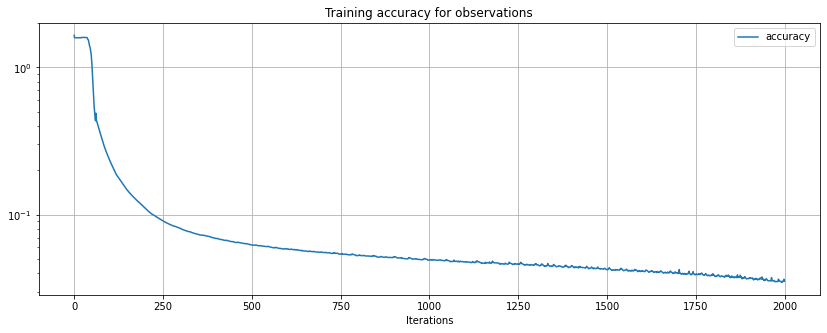

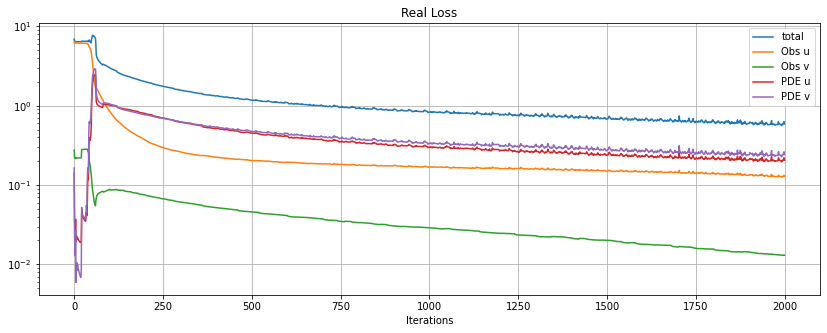

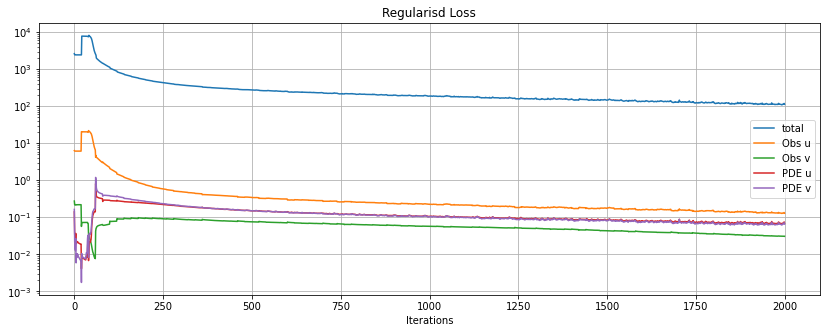

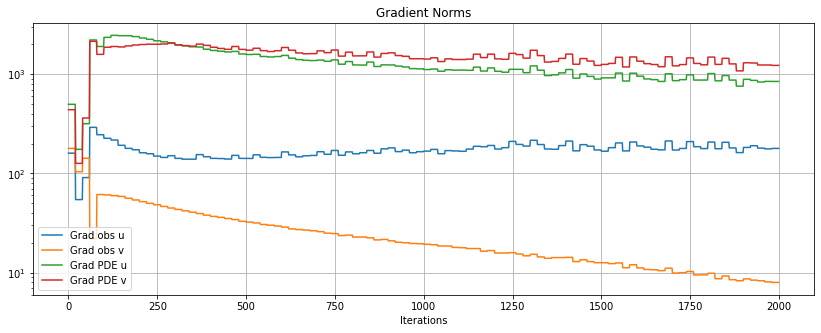

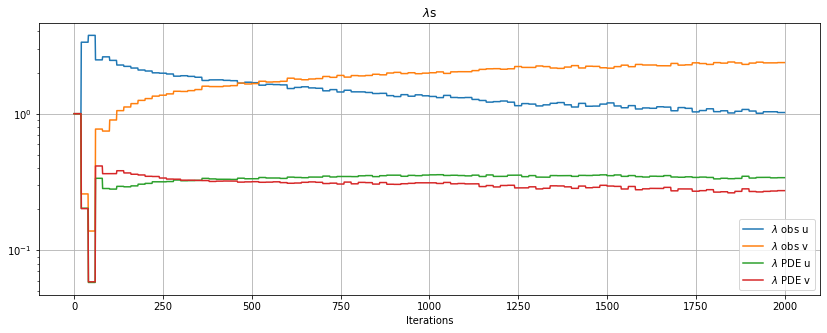

In [9]:
plot_result(results3_1)

In [63]:
model3.optimizer.lr.assign(2.5e-4)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.00025>

In [64]:
results3_2 = model3.train(epochs=200+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0
Training observations acc over epoch: 0.0322781578
total loss: 0.4840717539, total regularisd loss (sum of batches): 94.4522916826
obs u loss: 0.1163890541, obs v loss: 0.0127235690
pde u loss: 0.1676925989, pde v loss: 0.1872665317
lambda obs u: 0.9696320442, lambda obs v: 2.4387211953
lambda pde u: 0.3320605526, lambda pde v: 0.2595862079

Time taken: 113.12s

Start of epoch 10
Training observations acc over epoch: 0.0326887965
total loss: 0.5080922170, total regularisd loss (sum of batches): 97.3856840410
obs u loss: 0.1182746592, obs v loss: 0.0124805028
pde u loss: 0.1773264070, pde v loss: 0.2000106480
lambda obs u: 0.9696320442, lambda obs v: 2.4387211953
lambda pde u: 0.3320605526, lambda pde v: 0.2595862079

Time taken: 311.68s

Start of epoch 20
Training observations acc over epoch: 0.0324047469
total loss: 0.5051628569, total regularisd loss (sum of batches): 96.6937161107
obs u loss: 0.1172730712, obs v loss: 0.0123458027
pde u loss: 0.1766595618, pde v lo

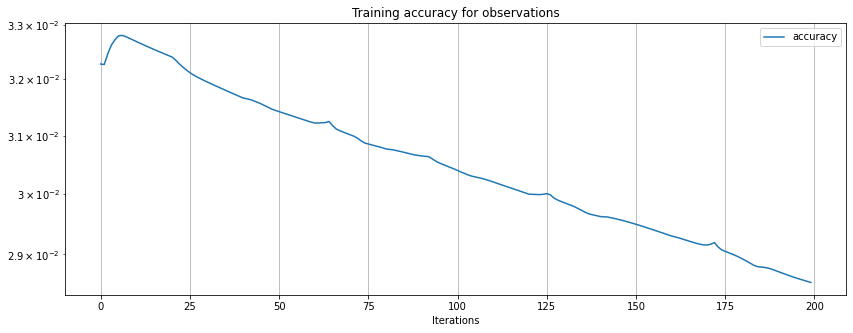

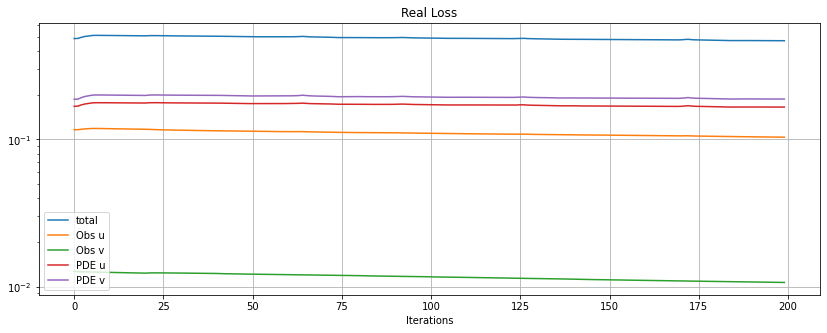

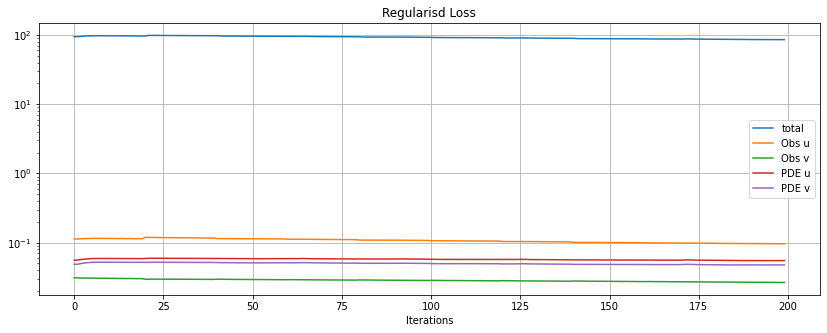

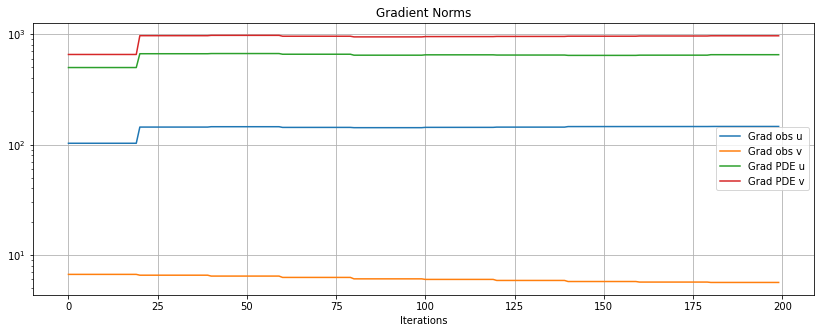

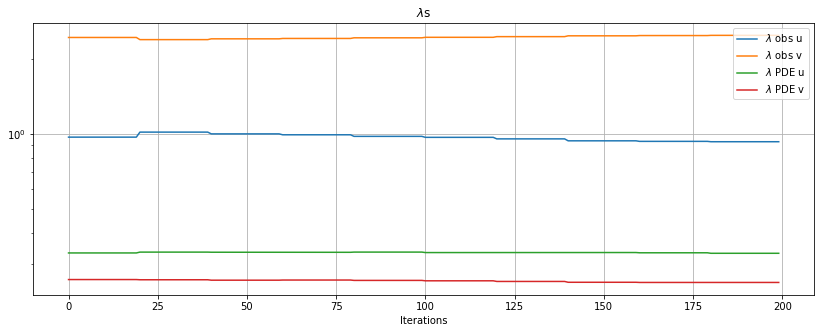

In [68]:
plot_result(results3_2)

In [94]:
results3_3 = model3.train(epochs=1200+1,
                      batch_size=dataset.x_size//380,
                      dataset=dataset,
                      print_interval=10,
                      stop_threshold=9e-5,
                      sample_losses=True, 
                      sample_parameters=True,
                      sample_regularisations=True,
                      sample_gradients=True,
                      regularise=True,
                      regularise_interval = 20
                     )


Start of epoch 0
Training observations acc over epoch: 0.0285328384
total loss: 0.4678100458, total regularisd loss (sum of batches): 84.7940857677
obs u loss: 0.1034920889, obs v loss: 0.0106392991
pde u loss: 0.1656176198, pde v loss: 0.1880610381
lambda obs u: 0.9107003373, lambda obs v: 2.5079162851
lambda pde u: 0.3312615610, lambda pde v: 0.2501218165

Time taken: 112.90s

Start of epoch 10
Training observations acc over epoch: 0.0283601247
total loss: 0.4649730639, total regularisd loss (sum of batches): 84.2425643119
obs u loss: 0.1029159118, obs v loss: 0.0105245697
pde u loss: 0.1643992361, pde v loss: 0.1871333464
lambda obs u: 0.9107003373, lambda obs v: 2.5079162851
lambda pde u: 0.3312615610, lambda pde v: 0.2501218165

Time taken: 313.07s

Start of epoch 20
Training observations acc over epoch: 0.0281619262
total loss: 0.4623293477, total regularisd loss (sum of batches): 83.7114446626
obs u loss: 0.1022099763, obs v loss: 0.0104377007
pde u loss: 0.1635083252, pde v lo


Start of epoch 220
Training observations acc over epoch: 0.0251143556
total loss: 0.4219619763, total regularisd loss (sum of batches): 73.3083929888
obs u loss: 0.0916249703, obs v loss: 0.0088324323
pde u loss: 0.1488928301, pde v loss: 0.1726117435
lambda obs u: 0.8428109597, lambda obs v: 2.5526960290
lambda pde u: 0.3479374553, lambda pde v: 0.2565555560

Time taken: 396.52s

Start of epoch 230
Training observations acc over epoch: 0.0251756068
total loss: 0.4217950451, total regularisd loss (sum of batches): 74.5562242723
obs u loss: 0.0918744623, obs v loss: 0.0088279870
pde u loss: 0.1488237782, pde v loss: 0.1722688176
lambda obs u: 0.8428109597, lambda obs v: 2.5526960290
lambda pde u: 0.3479374553, lambda pde v: 0.2565555560

Time taken: 313.15s

Start of epoch 240
Training observations acc over epoch: 0.0249764081
total loss: 0.4169718047, total regularisd loss (sum of batches): 73.8081341424
obs u loss: 0.0911357573, obs v loss: 0.0087699093
pde u loss: 0.1470838240, pde 


Start of epoch 440
Training observations acc over epoch: 0.0227104146
total loss: 0.3868540005, total regularisd loss (sum of batches): 66.3048705571
obs u loss: 0.0832158822, obs v loss: 0.0076257659
pde u loss: 0.1366657915, pde v loss: 0.1593465609
lambda obs u: 0.8049310437, lambda obs v: 2.5810442350
lambda pde u: 0.3526297495, lambda pde v: 0.2613949718

Time taken: 396.54s

Start of epoch 450
Training observations acc over epoch: 0.0226314366
total loss: 0.3850294935, total regularisd loss (sum of batches): 66.8943855088
obs u loss: 0.0829036773, obs v loss: 0.0076220637
pde u loss: 0.1361974567, pde v loss: 0.1583062959
lambda obs u: 0.8049310437, lambda obs v: 2.5810442350
lambda pde u: 0.3526297495, lambda pde v: 0.2613949718

Time taken: 313.17s

Start of epoch 460
Training observations acc over epoch: 0.0225026235
total loss: 0.3830203592, total regularisd loss (sum of batches): 66.5451385123
obs u loss: 0.0824281274, obs v loss: 0.0075823763
pde u loss: 0.1357903855, pde 


Start of epoch 660
Training observations acc over epoch: 0.0207161922
total loss: 0.3546563628, total regularisd loss (sum of batches): 62.7248037174
obs u loss: 0.0759433739, obs v loss: 0.0069213645
pde u loss: 0.1260980700, pde v loss: 0.1456935543
lambda obs u: 0.7980789004, lambda obs v: 2.5619775395
lambda pde u: 0.3675061119, lambda pde v: 0.2724374482

Time taken: 396.54s

Start of epoch 670
Training observations acc over epoch: 0.0206491258
total loss: 0.3548000972, total regularisd loss (sum of batches): 62.4845574546
obs u loss: 0.0757022339, obs v loss: 0.0068942586
pde u loss: 0.1261097452, pde v loss: 0.1460938595
lambda obs u: 0.7980789004, lambda obs v: 2.5619775395
lambda pde u: 0.3675061119, lambda pde v: 0.2724374482

Time taken: 313.19s

Start of epoch 680
Training observations acc over epoch: 0.0206973478
total loss: 0.3573011576, total regularisd loss (sum of batches): 62.8035123872
obs u loss: 0.0759108501, obs v loss: 0.0068785471
pde u loss: 0.1268763167, pde 


Start of epoch 880
Training observations acc over epoch: 0.0194194354
total loss: 0.3442417988, total regularisd loss (sum of batches): 58.3349458895
obs u loss: 0.0714120350, obs v loss: 0.0062656940
pde u loss: 0.1220108676, pde v loss: 0.1445532021
lambda obs u: 0.7602424779, lambda obs v: 2.6372799600
lambda pde u: 0.3515218596, lambda pde v: 0.2509557024

Time taken: 396.76s

Start of epoch 890
Training observations acc over epoch: 0.0190791693
total loss: 0.3377329857, total regularisd loss (sum of batches): 56.0442757276
obs u loss: 0.0701283817, obs v loss: 0.0061883117
pde u loss: 0.1199527043, pde v loss: 0.1414635881
lambda obs u: 0.7602424779, lambda obs v: 2.6372799600
lambda pde u: 0.3515218596, lambda pde v: 0.2509557024

Time taken: 313.29s

Start of epoch 900
Training observations acc over epoch: 0.0190564077
total loss: 0.3414207909, total regularisd loss (sum of batches): 56.4072817622
obs u loss: 0.0700667814, obs v loss: 0.0061588645
pde u loss: 0.1212063934, pde 


Start of epoch 1100
Training observations acc over epoch: 0.0179258157
total loss: 0.3162235213, total regularisd loss (sum of batches): 53.4342459159
obs u loss: 0.0658925268, obs v loss: 0.0058107600
pde u loss: 0.1124111851, pde v loss: 0.1321090494
lambda obs u: 0.7755948381, lambda obs v: 2.5719220935
lambda pde u: 0.3772960661, lambda pde v: 0.2751870023

Time taken: 396.52s

Start of epoch 1110
Training observations acc over epoch: 0.0182743017
total loss: 0.3278474280, total regularisd loss (sum of batches): 56.7880747075
obs u loss: 0.0672222083, obs v loss: 0.0058749904
pde u loss: 0.1165716057, pde v loss: 0.1381786235
lambda obs u: 0.7755948381, lambda obs v: 2.5719220935
lambda pde u: 0.3772960661, lambda pde v: 0.2751870023

Time taken: 313.20s

Start of epoch 1120
Training observations acc over epoch: 0.0178609528
total loss: 0.3148141516, total regularisd loss (sum of batches): 54.9149183047
obs u loss: 0.0655889581, obs v loss: 0.0058548318
pde u loss: 0.1119411587, p

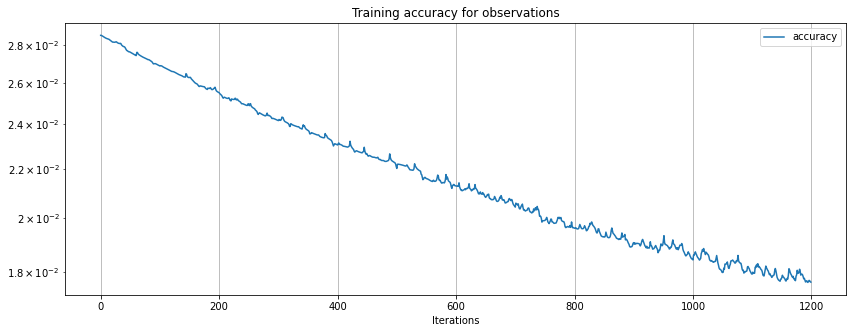

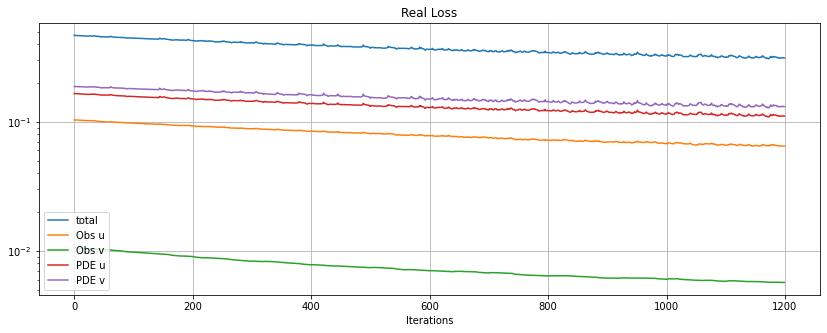

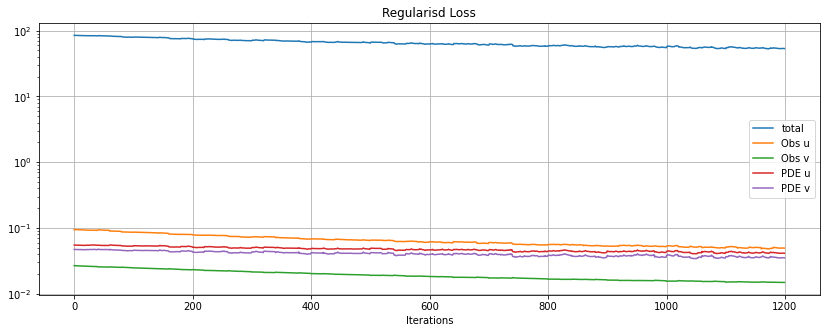

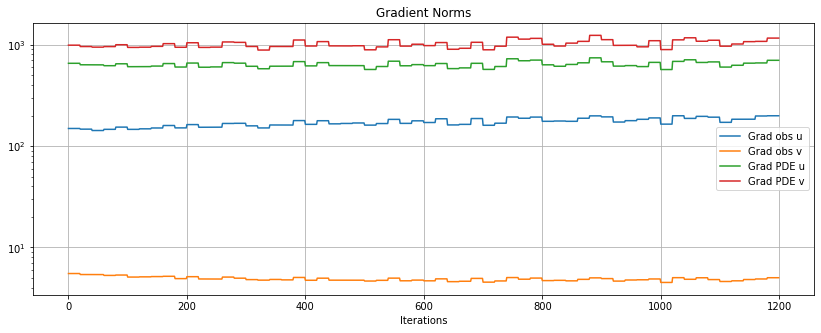

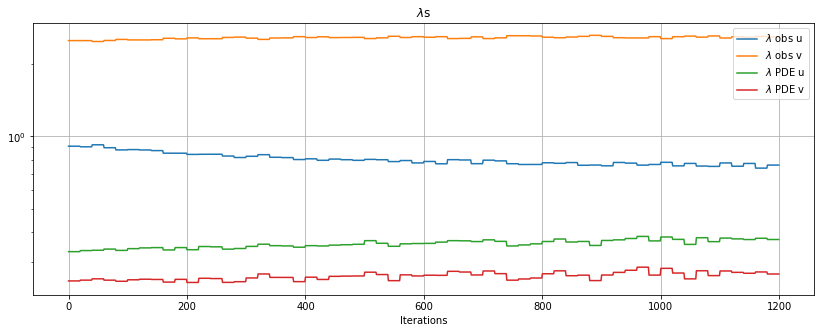

In [96]:
plot_result(results3_3)

In [95]:
model3.save("/end/home/rh2310/save_tests", "model_100_by_100_dense_params")

In [ ]:
## model3 = tu.TINN.restore("/end/home/rh2310/save_tests", "model_100_by_100_dense_params")
pinn3 = model3.pinn
pde_loss3 = model3.pde_residual

640.0
2.0500405063689455 2.8141502795583957


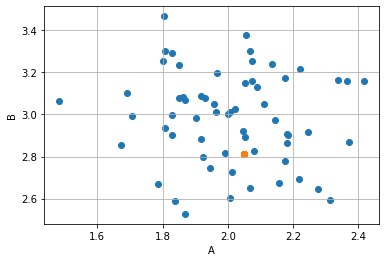

In [131]:
x_domain = dataset.simulations[0].L[0] * np.linspace(0, 1, dataset.simulations[0].n[0])
y_domain = dataset.simulations[0].L[1] * np.linspace(0, 1, dataset.simulations[0].n[1])
x_size = dataset.simulations[0].n[0]
y_size = dataset.simulations[0].n[1]
N2 = x_size * y_size


T_test_index = -1#119
print(dataset.ls_ts[0][T_test_index])
X_test, Y_test = np.meshgrid(x_domain, y_domain, sparse=False, indexing="ij")
XX_test = X_test.flatten()  # N2 x 1
YY_test = Y_test.flatten()  # N2 x 1
TT_test = np.repeat(dataset.ls_ts[0][T_test_index], N2)  # 1 x N2

#A_test = np.repeat(dataset.simulations[0].parameters["A"] + 1, N2)
A_M = 2
B_M = 3
std_AB = .1
(A, B ) = np.random.normal((A_M, B_M), (std_AB, std_AB), size=2)
while A in As and B in Bs and std_AB > 0:
    (A, B ) = np.random.normal((A_M, B_M), (std_AB, std_AB), size=2)
    
print(A, B)
A_test = np.repeat(A, N2)
#B_test = np.repeat(dataset.simulations[0].parameters["B"] + 1, N2)
B_test = np.repeat(B, N2)

plt.scatter(As, Bs)
plt.scatter(A_test, B_test)
plt.xlabel("A")
plt.ylabel("B")
plt.grid()
plt.show()

In [132]:
output_test = pinn3(np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
output_test = np.array([ output_test[:, i].numpy().reshape((x_size, y_size)) for i in range(output_test.shape[1])]) 

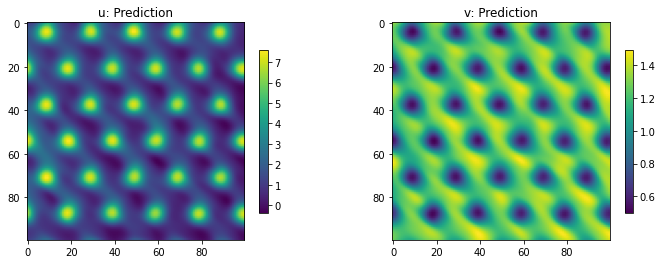

In [133]:
node_names = ["u", "v"]
# _ = plt.figure(figsize=(12,4))
# for i, name in enumerate(node_names):
#     plt.subplot(1, 2, i+1)
#     plt.title(f"{name}: Observation")
#     plt.imshow(data[i,:, :, T_test_index])
#     plt.colorbar(shrink=.75)

# plt.show()


_ = plt.figure(figsize=(12,4))
for i, name in enumerate(node_names):
    plt.subplot(1, 2, i+1)
    #rmse = np.sqrt(np.mean((output_test[i,:, :] - data[i,:, :, T_test_index])**2))
    #plt.title(f"{name}: Prediction, RMSE: {rmse:.4f}")
    plt.title(f"{name}: Prediction")
    
    plt.imshow(output_test[i,:, :])
    plt.colorbar(shrink=.75)

plt.show()

In [134]:
test_outputs, test_pde_u, test_pde_v = pde_loss3.residual(pinn3, np.vstack([XX_test, YY_test, TT_test, A_test, B_test]).T)
test_outputs = test_outputs.numpy()
test_pde_u = test_pde_u.numpy().reshape((x_size, y_size))
test_pde_v = test_pde_v.numpy().reshape((x_size, y_size))

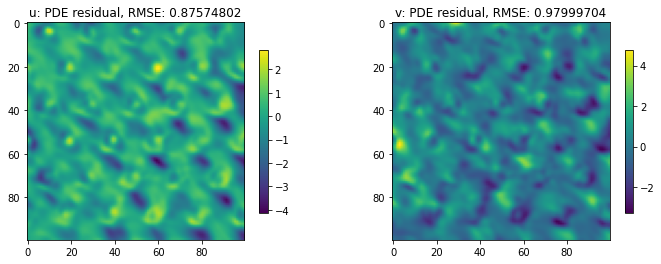

In [135]:
_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
plt.imshow(test_pde_u)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
plt.imshow(test_pde_v)
plt.colorbar(shrink=.75)

plt.show()

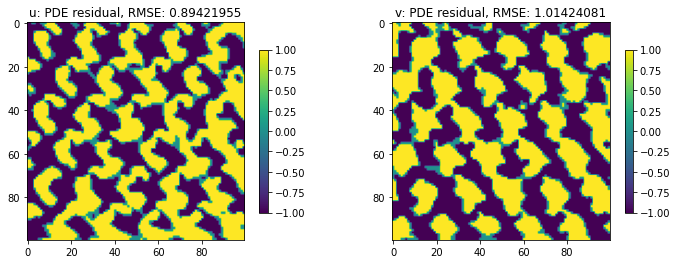

In [120]:
max_L = .10
min_L = -.10

_ = plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)

d = test_pde_u.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"u: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)
plt.colorbar(shrink=.75)
plt.subplot(1, 2, 2)
d = test_pde_v.copy()
rmse = np.sqrt(np.mean(d**2))
plt.title(f"v: PDE residual, RMSE: {rmse:.8f}")
d[(d >= min_L) & (d <= max_L)] = 0
d[d > max_L] = 1
d[d < min_L] = -1
plt.imshow(d)

plt.colorbar(shrink=.75)

plt.show()